# 평가원

# 교육청

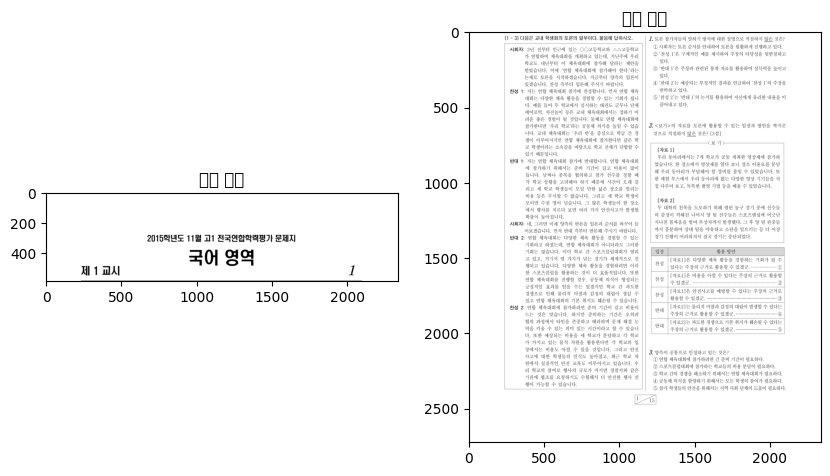

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# 이미지 불러오기
image_path = r'/content/drive/MyDrive/빅데이터 7기/final/2015_G1_11_KOR/KOR_page0.png'  # 올바른 경로로 설정
image = cv2.imread(image_path, cv2.IMREAD_COLOR)

# 이미지가 제대로 로드되지 않았는지 확인
if image is None:
    print(f"이미지를 불러오지 못했습니다: {image_path}")
else:
    # 그레이스케일로 변환
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 이진화
    _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)

    # 윤곽선 찾기
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 가로선 찾기
    horizontal_lines = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w > 700 and h < 50:  # 너비가 특정 값 이상이고 높이가 작은 가로선 찾기
            horizontal_lines.append((x, y, w, h))

    # 제일 작은 y값을 가진 가로선 찾기
    if horizontal_lines:
        horizontal_lines.sort(key=lambda line: line[1])  # y 값을 기준으로 정렬
        smallest_y_line = horizontal_lines[0]  # y 값이 제일 작은 가로선
        x, y, w, h = smallest_y_line
        cut_line = y + h // 2  # 가로선의 중심 위치 계산

        upper_part = image[:cut_line, :]  # 가로선 중심까지 포함
        lower_part = image[cut_line:, :]  # 가로선 중심 아래부터 시작

        # # 이미지 저장
        # upper_part_path = '/mnt/data/upper_part.png'
        # lower_part_path = '/mnt/data/lower_part.png'
        # cv2.imwrite(upper_part_path, upper_part)
        # cv2.imwrite(lower_part_path, lower_part)

        # 이미지 출력
        plt.figure(figsize=(10, 8))

        plt.subplot(1, 2, 1)
        plt.title('상단 부분')
        plt.imshow(cv2.cvtColor(upper_part, cv2.COLOR_BGR2RGB))

        plt.subplot(1, 2, 2)
        plt.title('하단 부분')
        plt.imshow(cv2.cvtColor(lower_part, cv2.COLOR_BGR2RGB))

        plt.show()

    else:
        print("500픽셀 근처에 가로로 긴 선을 찾을 수 없습니다.")


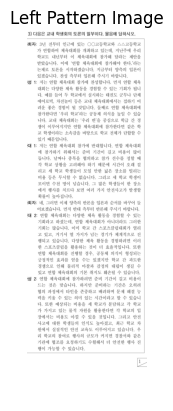

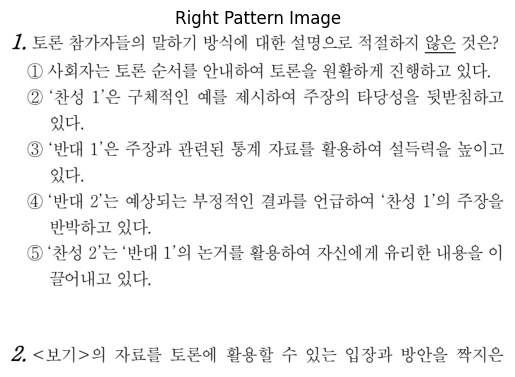

In [36]:
import easyocr
import re
import cv2
import numpy as np
import matplotlib.pyplot as plt

# EASYOCR 초기화
reader = easyocr.Reader(['ko'], gpu=True)  # 사용할 언어 설정

def find_pattern_area(image, pattern):
    # 이미지의 너비와 높이를 가져옴
    height, width, _ = image.shape

    # 이미지를 좌우로 절반으로 나눔
    left_image = image[:, :width//2]
    right_image = image[:, width//2:]

    # 좌우 각각의 이미지에 대해 텍스트 인식 수행
    left_results = reader.readtext(left_image)
    right_results = reader.readtext(right_image)

    # 정규식을 사용하여 패턴 매칭
    def get_pattern_area(results):
        pattern_start = None
        pattern_end = None
        found_first_pattern = False

        for detection in results:
            text = detection[1]
            if re.search(pattern, text):
                bbox = detection[0]

                if not found_first_pattern:
                    pattern_start = bbox
                    found_first_pattern = True
                else:
                    pattern_end = bbox
                    break

        # 패턴의 시작과 끝 사이의 영역을 반환
        if pattern_start and pattern_end:
            # bbox 좌표에서 네 개의 값 중 가장 작은 x, y 좌표와 가장 큰 x, y 좌표를 추출
            x1 = min(pattern_start[0][0], pattern_end[0][0])
            y1 = min(pattern_start[0][1], pattern_end[0][1])
            x2 = max(pattern_start[2][0], pattern_end[2][0])
            y2 = max(pattern_start[2][1], pattern_end[2][1])
            return (x1, y1, x2, y2)
        elif pattern_start and not pattern_end:
            return (pattern_start[0][0], pattern_start[0][1], width//2, height)
        else:
            return None

    # 좌측 이미지에서 패턴 영역 찾기
    left_pattern_area = get_pattern_area(left_results)
    if left_pattern_area:
        left_pattern_image = left_image[int(left_pattern_area[1]):int(left_pattern_area[3]),
                                       int(left_pattern_area[0]):int(left_pattern_area[2])]
    else:
        left_pattern_image = None

    # 우측 이미지에서 패턴 영역 찾기
    right_pattern_area = get_pattern_area(right_results)
    if right_pattern_area:
        right_pattern_image = right_image[int(right_pattern_area[1]):int(right_pattern_area[3]),
                                         int(right_pattern_area[0]):int(right_pattern_area[2])]
    else:
        right_pattern_image = None

    return left_pattern_image, right_pattern_image

# 이미지 경로와 패턴 정의
image_path = '/content/drive/MyDrive/빅데이터 7기/final/2015_G1_11_KOR/KOR_page0.png'
pattern = r'\[\d+[^\]]*\]|\d+\]|\d+\.'

# 이미지 OpenCV로 읽기
image = cv2.imread(image_path, cv2.IMREAD_COLOR)

# 패턴 영역을 찾아 좌우 이미지 자르기
left_pattern_image, right_pattern_image = find_pattern_area(image, pattern)

# 좌측 결과 확인 (matplotlib.pyplot으로 이미지 보기)
if left_pattern_image is not None:
    left_pattern_image_rgb = cv2.cvtColor(left_pattern_image, cv2.COLOR_BGR2RGB)
    plt.imshow(left_pattern_image_rgb)
    plt.axis('off')
    plt.title('Left Pattern Image')
    plt.show()
else:
    print("좌측 이미지에서 해당 패턴을 찾을 수 없습니다.")

# 우측 결과 확인 (matplotlib.pyplot으로 이미지 보기)
if right_pattern_image is not None:
    right_pattern_image_rgb = cv2.cvtColor(right_pattern_image, cv2.COLOR_BGR2RGB)
    plt.imshow(right_pattern_image_rgb)
    plt.axis('off')
    plt.title('Right Pattern Image')
    plt.show()
else:
    print("우측 이미지에서 해당 패턴을 찾을 수 없습니다.")


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


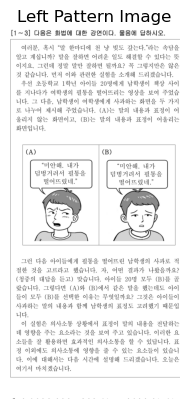

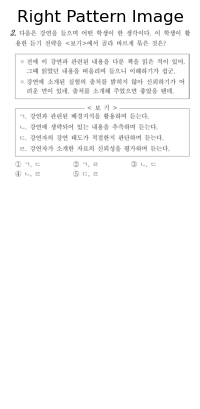

In [10]:
import easyocr
import re
import cv2
import numpy as np
import matplotlib.pyplot as plt

# EASYOCR 초기화
reader = easyocr.Reader(['ko'])  # 사용할 언어 설정

def find_pattern_area(image, pattern, padding=40):
    # 이미지의 너비와 높이를 가져옴
    height, width, _ = image.shape

    # 이미지를 좌우로 절반으로 나눔
    left_image = image[:, :width//2]
    right_image = image[:, width//2:]

    # 좌우 각각의 이미지에 대해 텍스트 인식 수행
    left_results = reader.readtext(left_image)
    right_results = reader.readtext(right_image)

    # 정규식을 사용하여 패턴 매칭
    def get_pattern_area(results):
        pattern_start = None
        pattern_end = None
        found_first_pattern = False

        for detection in results:
            text = detection[1]
            if re.search(pattern, text):
                bbox = detection[0]

                if not found_first_pattern:
                    pattern_start = bbox
                    found_first_pattern = True
                else:
                    pattern_end = bbox
                    break

        # 패턴의 시작과 끝 사이의 영역을 반환
        if pattern_start and pattern_end:
            # bbox 좌표에서 네 개의 값 중 가장 작은 x, y 좌표와 가장 큰 x, y 좌표를 추출
            x1 = min(pattern_start[0][0], pattern_end[0][0])
            y1 = min(pattern_start[0][1], pattern_end[0][1])
            x2 = max(pattern_start[2][0], pattern_end[2][0])
            y2 = max(pattern_start[2][1], pattern_end[2][1]) - padding
            return (x1, y1, x2, y2)
        elif pattern_start and not pattern_end:
            return (pattern_start[0][0], pattern_start[0][1], width//2, height - padding)
        else:
            return None

    # 좌측 이미지에서 패턴 영역 찾기
    left_pattern_area = get_pattern_area(left_results)
    if left_pattern_area:
        left_pattern_image = left_image[int(left_pattern_area[1]):int(left_pattern_area[3]),
                                       int(left_pattern_area[0]):int(left_pattern_area[2])]
    else:
        left_pattern_image = None

    # 우측 이미지에서 패턴 영역 찾기
    right_pattern_area = get_pattern_area(right_results)
    if right_pattern_area:
        right_pattern_image = right_image[int(right_pattern_area[1]):int(right_pattern_area[3]),
                                         int(right_pattern_area[0]):int(right_pattern_area[2])]
    else:
        right_pattern_image = None

    return left_pattern_image, right_pattern_image

# 이미지 경로와 패턴 정의
image_path = r'C:\Users\BIG3-06\Documents\KDT_Bigdata_7\0614-0726_Final_project\preprocessing\test\2015_G1_3_KOR\kor_page0.png'
pattern = r'\[(\d+)|\d+\]|\d+\.'

# 이미지 OpenCV로 읽기
image = cv2.imread(image_path, cv2.IMREAD_COLOR)

# 이미지 로드 확인
if image is None:
    raise FileNotFoundError(f"이미지를 찾을 수 없습니다: {image_path}")

# 패턴 영역을 찾아 좌우 이미지 자르기
left_pattern_image, right_pattern_image = find_pattern_area(image, pattern, padding=40)

# 좌측 결과 확인 (matplotlib.pyplot으로 이미지 보기)
if left_pattern_image is not None:
    left_pattern_image_rgb = cv2.cvtColor(left_pattern_image, cv2.COLOR_BGR2RGB)
    plt.imshow(left_pattern_image_rgb)
    plt.axis('off')
    plt.title('Left Pattern Image')
    plt.show()
else:
    print("좌측 이미지에서 해당 패턴을 찾을 수 없습니다.")

# 우측 결과 확인 (matplotlib.pyplot으로 이미지 보기)
if right_pattern_image is not None:
    right_pattern_image_rgb = cv2.cvtColor(right_pattern_image, cv2.COLOR_BGR2RGB)
    plt.imshow(right_pattern_image_rgb)
    plt.axis('off')
    plt.title('Right Pattern Image')
    plt.show()
else:
    print("우측 이미지에서 해당 패턴을 찾을 수 없습니다.")


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


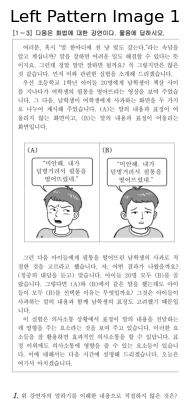

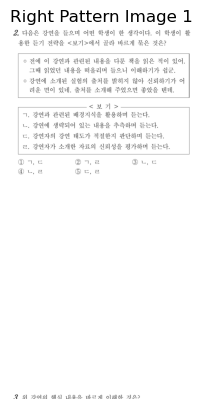

In [16]:
import easyocr
import re
import cv2
import numpy as np
import matplotlib.pyplot as plt

# EASYOCR 초기화
reader = easyocr.Reader(['ko'], gpu=True)  # 사용할 언어 설정

def find_pattern_areas(image, pattern1, pattern2, padding=10):
    # 이미지의 너비와 높이를 가져옴
    height, width, _ = image.shape

    # 이미지를 좌우로 절반으로 나눔
    left_image = image[:, :width//2]
    right_image = image[:, width//2:]

    # 좌우 각각의 이미지에 대해 텍스트 인식 수행
    left_results = reader.readtext(left_image)
    right_results = reader.readtext(right_image)

    # 정규식을 사용하여 패턴 매칭
    def get_pattern_areas(results, image_half_width):
        pattern_areas = []
        found_first_pattern = False
        pattern_start = None

        for detection in results:
            text = detection[1]
            if re.search(pattern1, text) or re.search(pattern2, text):
                bbox = detection[0]
                if not found_first_pattern:
                    pattern_start = bbox
                    found_first_pattern = True
                else:
                    pattern_end = bbox
                    x1 = min(pattern_start[0][0], pattern_end[0][0])
                    y1 = min(pattern_start[0][1], pattern_end[0][1])
                    x2 = max(pattern_start[2][0], pattern_end[2][0])
                    y2 = max(pattern_start[2][1], pattern_end[2][1]) - padding
                    pattern_areas.append((x1, y1, x2, y2))
                    pattern_start = pattern_end
                    found_first_pattern = False

        if found_first_pattern:
            x1 = pattern_start[0][0]
            y1 = pattern_start[0][1]
            x2 = image_half_width
            y2 = height - padding
            pattern_areas.append((x1, y1, x2, y2))

        return pattern_areas

    # 좌측 이미지에서 패턴 영역들 찾기
    left_pattern_areas = get_pattern_areas(left_results, width//2)
    left_pattern_images = [left_image[int(area[1]):int(area[3]), int(area[0]):int(area[2])] for area in left_pattern_areas]

    # 우측 이미지에서 패턴 영역들 찾기
    right_pattern_areas = get_pattern_areas(right_results, width//2)
    right_pattern_images = [right_image[int(area[1]):int(area[3]), int(area[0]):int(area[2])] for area in right_pattern_areas]

    return left_pattern_images, right_pattern_images

# 이미지 경로와 패턴 정의
image_path = r'C:\Users\BIG3-06\Documents\KDT_Bigdata_7\0614-0726_Final_project\preprocessing\test\2015_G1_3_KOR\kor_page0.png'
pattern1 = r'\[\d+\s*~\s*\d+\]|\[\d+~\d+\]|\[\d+\s*~\d+\]|\[\d+~\s*\d+\]'
pattern2 = r'\d+\.'

# 이미지 OpenCV로 읽기
image = cv2.imread(image_path, cv2.IMREAD_COLOR)

# 이미지 로드 확인
if image is None:
    raise FileNotFoundError(f"이미지를 찾을 수 없습니다: {image_path}")

# 패턴 영역들을 찾아 좌우 이미지 자르기
left_pattern_images, right_pattern_images = find_pattern_areas(image, pattern1, pattern2, padding=10)

# 좌측 결과 확인 (matplotlib.pyplot으로 이미지 보기)
for idx, pattern_image in enumerate(left_pattern_images):
    if pattern_image is not None:
        left_pattern_image_rgb = cv2.cvtColor(pattern_image, cv2.COLOR_BGR2RGB)
        plt.imshow(left_pattern_image_rgb)
        plt.axis('off')
        plt.title(f'Left Pattern Image {idx+1}')
        plt.show()

# 우측 결과 확인 (matplotlib.pyplot으로 이미지 보기)
for idx, pattern_image in enumerate(right_pattern_images):
    if pattern_image is not None:
        right_pattern_image_rgb = cv2.cvtColor(pattern_image, cv2.COLOR_BGR2RGB)
        plt.imshow(right_pattern_image_rgb)
        plt.axis('off')
        plt.title(f'Right Pattern Image {idx+1}')
        plt.show()


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


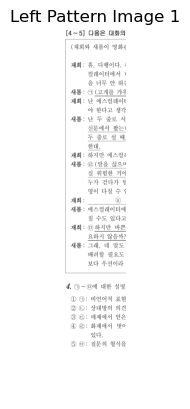

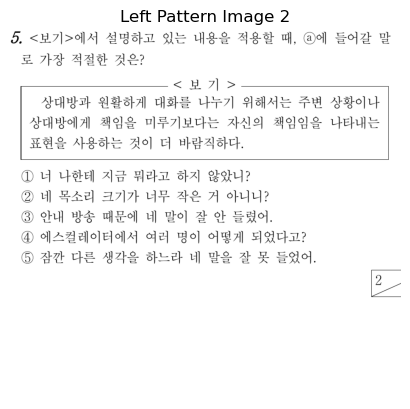

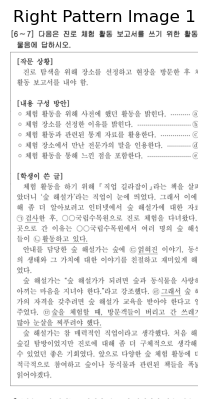

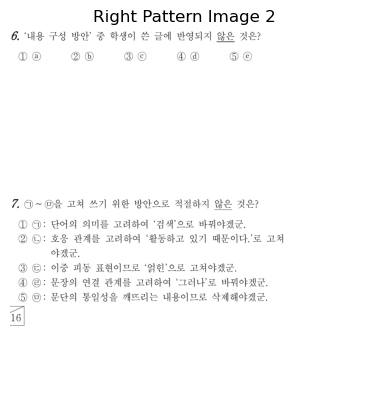

In [29]:
import easyocr
import re
import cv2
import numpy as np
import matplotlib.pyplot as plt

# EASYOCR 초기화
reader = easyocr.Reader(['ko'], gpu=True)  # 사용할 언어 설정

def find_pattern_areas(image, pattern1, pattern2, padding=50):
    # 이미지의 너비와 높이를 가져옴
    height, width, _ = image.shape

    # 이미지를 좌우로 절반으로 나눔
    left_image = image[:, :width//2]
    right_image = image[:, width//2:]

    # 좌우 각각의 이미지에 대해 텍스트 인식 수행
    left_results = reader.readtext(left_image)
    right_results = reader.readtext(right_image)

    # 정규식을 사용하여 패턴 매칭
    def get_pattern_areas(results, image_half_width):
        pattern_areas = []
        pattern_start = None

        for detection in results:
            text = detection[1]
            if re.search(pattern1, text) or re.search(pattern2, text):
                bbox = detection[0]
                if pattern_start is None:
                    pattern_start = bbox
                else:
                    pattern_end = bbox
                    x1 = min(pattern_start[0][0], pattern_end[0][0])
                    y1 = min(pattern_start[0][1], pattern_end[0][1])
                    x2 = max(pattern_start[2][0], pattern_end[2][0])
                    y2 = max(pattern_start[2][1], pattern_end[2][1]) - padding
                    pattern_areas.append((x1, y1, x2, y2))
                    pattern_start = pattern_end

        if pattern_start:
            x1 = pattern_start[0][0]
            y1 = pattern_start[0][1]
            x2 = image_half_width
            y2 = height
            pattern_areas.append((x1, y1, x2, y2))

        return pattern_areas

    # 좌측 이미지에서 패턴 영역들 찾기
    left_pattern_areas = get_pattern_areas(left_results, width//2)
    left_pattern_images = [left_image[int(area[1]):int(area[3]), int(area[0]):int(area[2])] for area in left_pattern_areas]

    # 우측 이미지에서 패턴 영역들 찾기
    right_pattern_areas = get_pattern_areas(right_results, width//2)
    right_pattern_images = [right_image[int(area[1]):int(area[3]), int(area[0]):int(area[2])] for area in right_pattern_areas]

    return left_pattern_images, right_pattern_images

# 이미지 경로와 패턴 정의
image_path = r'C:\Users\BIG3-06\Documents\KDT_Bigdata_7\0614-0726_Final_project\preprocessing\test\2015_G1_3_KOR\kor_page1.png'
pattern1 = r'\[\d+\s*~\s*\d+\]|\[\d+~\d+\]|\[\d+\s*~\d+\]|\[\d+~\s*\d+\]'
pattern2 = r'\d+\.'

# 이미지 OpenCV로 읽기
image = cv2.imread(image_path, cv2.IMREAD_COLOR)

# 이미지 로드 확인
if image is None:
    raise FileNotFoundError(f"이미지를 찾을 수 없습니다: {image_path}")

# 패턴 영역들을 찾아 좌우 이미지 자르기
left_pattern_images, right_pattern_images = find_pattern_areas(image, pattern1, pattern2, padding=40)

# 좌측 결과 확인 (matplotlib.pyplot으로 이미지 보기)
for idx, pattern_image in enumerate(left_pattern_images):
    if pattern_image is not None:
        left_pattern_image_rgb = cv2.cvtColor(pattern_image, cv2.COLOR_BGR2RGB)
        plt.imshow(left_pattern_image_rgb)
        plt.axis('off')
        plt.title(f'Left Pattern Image {idx+1}')
        plt.show()

# 우측 결과 확인 (matplotlib.pyplot으로 이미지 보기)
for idx, pattern_image in enumerate(right_pattern_images):
    if pattern_image is not None:
        right_pattern_image_rgb = cv2.cvtColor(pattern_image, cv2.COLOR_BGR2RGB)
        plt.imshow(right_pattern_image_rgb)
        plt.axis('off')
        plt.title(f'Right Pattern Image {idx+1}')
        plt.show()


# 깃허브 참고

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


[]

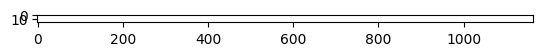

In [25]:
from matplotlib.pyplot import imshow
from PIL import Image

f_name = r'C:\Users\hana9\preprocessing\a_kor_test\2015_G1_11_KOR\cropped\2015_G1_11_KOR_left__page5.png'

%matplotlib inline
pil_im = Image.open(f_name, 'r')
imshow(pil_im)

import easyocr

# easy-ocr
reader = easyocr.Reader(['ko','en'])
txt = reader.readtext(f_name)
txt

In [5]:
# PNG img to OCR txt
## GPU 있을시 자동으로 GPU 동작

import easyocr

reader = easyocr.Reader(['ko','en'])
ocr_txt = reader.readtext(r'test\2015_G1_11_KOR\cropped\2015_G1_11_KOR_right_MATH_page0.png')

# bounding box, text, confident level.
for b_box, text, cf_level in ocr_txt:
    print(b_box, text, cf_level)

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


[[15, 107], [926, 107], [926, 159], [15, 159]] 1. 토론 참가자들의 말하기 방식에 대한 설명으로 적절하지 앞은 것은? 0.5510496571467529
[[40, 165], [905, 165], [905, 208], [40, 208]] @ 사회자는 토론 순서클 안내하여 토론올 원활하게 진행하고 있다 0.7087660727644781
[[88, 209], [933, 209], [933, 259], [88, 259]] '친성 1'은 구체적인 예름 제시하여 주장의 타당성올 뒷받침하고 0.5202136069891501
[[84, 262], [154, 262], [154, 305], [84, 305]] 있다. 0.7238795201273699
[[90, 305], [933, 305], [933, 355], [90, 355]] 반대 1' 은 주장과 관련된 통계  자료틀 활용하여 설득력올 높이고 0.33719500721709467
[[84, 358], [154, 358], [154, 401], [84, 401]] 있다. 0.7238795201273699
[[88, 403], [930, 403], [930, 451], [88, 451]] '반대 2'눈 예상되는 부정적인 결과루 언급하여 '친성 1 ' 의 주장올 0.30658893967679796
[[86, 452], [279, 452], [279, 496], [86, 496]] 반박하고 있다 0.9549166911095023
[[85, 497], [930, 497], [930, 545], [85, 545]] '친성 2'눈 '반대 1' 의 논거름 활용하여 자신에게 유리한 내용올 이 0.47546830455816086
[[84, 549], [279, 549], [279, 592], [84, 592]] 끌어내고 있다 0.9896528005594238
[[14, 687], [929, 687], [929, 732], [14, 732]] 2. <보기> 의 자료틀 토론에   활용할 수 있는 입장과 방

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


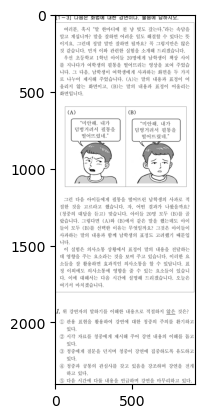

In [66]:
import cv2
import easyocr
import re
from PIL import Image
from matplotlib.pyplot import imshow

# 이미지 파일 경로
f_name = r'C:\Users\BIG3-06\Documents\KDT_Bigdata_7\0614-0726_Final_project\preprocessing\kor_test\2015_G1_03_KOR\cropped\2015_G1_03_KOR_left__page0.png'

# 이미지 열기
pil_im = Image.open(f_name, 'r')
imshow(pil_im)

# EasyOCR을 사용하여 숫자와 점을 인식
reader = easyocr.Reader(['ko', 'en'])
results = reader.readtext(f_name)

# 숫자와 점 다음 영역을 찾기 위한 초기 변수 설정
min_x = float('inf')
max_x = float('-inf')
min_y = float('inf')
max_y = float('-inf')

# 경계 상자의 최소 x, y 좌표 및 최대 x, y 좌표 찾기
for (bbox, text, prob) in results:
    for (x, y) in bbox:
        min_x = min(min_x, x)
        max_x = max(max_x, x)
        min_y = min(min_y, y)
        max_y = max(max_y, y)

# 이미지를 numpy 배열로 변환
image_cv = cv2.imread(f_name)
image_cv = cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB)

# 숫자와 점 다음 영역을 잘라냄
cropped_image = image_cv[min_y:max_y, min_x:max_x]

# 잘린 이미지 출력
imshow(cropped_image)


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


[([[234, 18], [1142, 18], [1142, 66], [234, 66]],
  '12. 다음 표틀 보면서 대화틀 듣고 두 사람이 선택할 상품올 고르시오',
  0.2210376652888934),
 ([[568, 104], [820, 104], [820, 143], [568, 143]],
  'Vitamin Product',
  0.7910076639899948),
 ([[309, 164], [425, 164], [425, 201], [309, 201]],
  'Product',
  0.6488898941577306),
 ([[465, 164], [614, 164], [614, 203], [465, 203]],
  'Ingredient',
  0.9499812363207762),
 ([[693, 164], [773, 164], [773, 203], [693, 203]],
  'Type',
  0.9999865889549255),
 ([[841, 164], [963, 164], [963, 203], [841, 203]],
  'Quantity',
  0.9848551066428227),
 ([[1019, 164], [1099, 164], [1099, 201], [1019, 201]],
  'Price',
  0.999855359358661),
 ([[353, 214], [377, 214], [377, 243], [353, 243]], 'A', 0.9902467100516823),
 ([[470, 211], [610, 211], [610, 248], [470, 248]],
  'Vitamin C',
  0.8771152043467698),
 ([[692, 210], [767, 210], [767, 251], [692, 251]],
  'Jelly',
  0.9999881114123143),
 ([[882, 212], [921, 212], [921, 245], [882, 245]], '60', 0.9979764556365589),
 ([[1026, 2

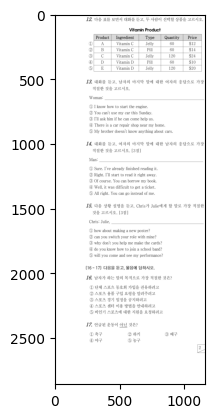

In [26]:
from matplotlib.pyplot import imshow
from PIL import Image

f_name = r'C:\Users\hana9\preprocessing\a_kor_test\2015_G1_11_KOR\cropped\2015_G1_11_KOR_right__page8.png'

%matplotlib inline
pil_im = Image.open(f_name, 'r')
imshow(pil_im)

import easyocr

# easy-ocr
reader = easyocr.Reader(['ko','en'])
txt = reader.readtext(f_name)
txt

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


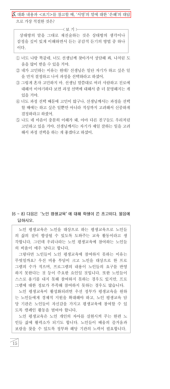

사용된 숫자 리스트: []
사용되지 않은 숫자 리스트: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]


In [18]:
import cv2
import easyocr
import re
from PIL import Image
import matplotlib.pyplot as plt

# 이미지 파일 경로
f_name = r'C:\Users\hana9\preprocessing\kor_test\2015_G1_11_KOR\cropped\2015_G1_11_KOR_right__page1.png'

# EasyOCR을 사용하여 텍스트 인식
reader = easyocr.Reader(['ko', 'en'])
results = reader.readtext(f_name)

# 정규 표현식으로 매칭되는 패턴들 정의
pattern1 = r'\[\d+\s*~\s*\d+\]|\[\d+~\d+\]|\[\d+\s*~\d+\]|\[\d+~\s*\d+\]'
pattern2 = r'\d+\.'
pattern3 = r'\[\d+\s*\d+\]|\[\d+\s*\]|\[\s*\d+\]'

# 패턴에 따라 적절한 영역 찾기
def find_pattern_bboxes(results, patterns):
    bboxes = []
    for pattern in patterns:
        for (bbox, text, prob) in results:
            if re.match(pattern, text):
                bboxes.append(bbox)
    return bboxes

# 이미지를 numpy 배열로 변환
image_cv = cv2.imread(f_name)
image_cv = cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB)

# 패턴에 따라 적절한 영역들 찾기
bboxes = find_pattern_bboxes(results, [pattern1, pattern2, pattern3])

# 찾은 영역들에 대해 처리
for bbox in bboxes:
    start_x, start_y = bbox[0]
    end_x, end_y = bbox[2]

    # 이미지 자르기
    cropped_image = image_cv[start_y:end_y, start_x:end_x]

    # 사각형 그리기
    cv2.rectangle(image_cv, (int(start_x), int(start_y)), (int(end_x), int(end_y)), (255, 0, 0), 2)

# 결과 이미지 출력
plt.imshow(image_cv)
plt.axis('off')
plt.show()

# EasyOCR에서 읽어온 전체 텍스트 추출
full_text = ""
for (bbox, text, prob) in results:
    full_text += text + "\n"

# 정규 표현식으로 매칭되는 숫자 찾기
matches = re.findall(pattern2, full_text)

# 매칭된 숫자를 리스트에서 제거하고 사용된 숫자 리스트 생성
used_numbers = []
for match in matches:
    number = int(match.rstrip('.'))
    # 숫자와 점을 제거하기 위해 빈 문자열로 대체
    full_text = full_text.replace(match, "")
    # 이미지에서 한 번만 사용된 숫자만 사용된 숫자 리스트에 추가
    if full_text.count(match) == 1:
        used_numbers.append(number)

# 1부터 45까지의 숫자 리스트 생성
all_numbers = list(range(1, 46))

# 사용된 숫자 리스트에서 숫자 제거하여 사용되지 않은 숫자 리스트 생성
unused_numbers = [num for num in all_numbers if num not in used_numbers]

# 결과 출력
print("사용된 숫자 리스트:", used_numbers)
print("사용되지 않은 숫자 리스트:", unused_numbers)


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


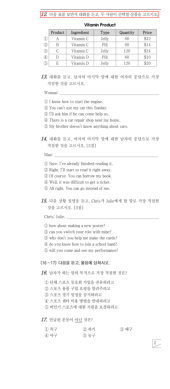

사용된 숫자 리스트: [12, 13, 14, 15, 16, 17]


In [56]:
import cv2
import easyocr
import re
from PIL import Image
import matplotlib.pyplot as plt

# 1부터 45까지의 숫자 리스트 생성
all_numbers = list(range(1, 46))

# 이미지 파일 경로 (예시)
image_files = [
    r'C:\Users\hana9\preprocessing\a_eng_test\2015_G1_11_ENG\cropped\2015_G1_11_ENG_left__page1.png',
    # 다른 이미지 파일들 추가
]

# EasyOCR을 사용하여 텍스트 인식
reader = easyocr.Reader(['ko', 'en'])

# 각 이미지에 대해 처리
for f_name in image_files:
    # EasyOCR을 사용하여 텍스트 인식
    results = reader.readtext(f_name)

    # EasyOCR에서 읽어온 전체 텍스트 추출
    full_text = ""
    for (bbox, text, prob) in results:
        full_text += text + "\n"

    # 정규 표현식으로 매칭되는 숫자 찾기
    pattern2 = r'\d+\.'
    matches = re.findall(pattern2, full_text)

    # 숫자를 정수로 변환하여 리스트에 저장
    used_numbers = []
    for match in matches:
        number = int(match.rstrip('.'))
        if number in all_numbers:
            all_numbers.remove(number)  # 사용된 숫자 리스트에서 제거
            used_numbers.append(number)

    # 이미지를 numpy 배열로 변환
    image_cv = cv2.imread(f_name)
    image_cv = cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB)

    # 패턴으로 사용할 숫자 리스트 생성
    patterns = [str(num) + '.' for num in used_numbers]

    # 패턴에 따라 적절한 영역 찾기
    def find_pattern_bbox(results, patterns):
        for pattern in patterns:
            for (bbox, text, prob) in results:
                if pattern in text:
                    return bbox
        return None

    # 패턴에 따라 적절한 영역 찾기
    bbox = find_pattern_bbox(results, patterns)

    if bbox is not None:
        # 시작점과 끝점 설정
        start_x, start_y = bbox[0]
        end_x, end_y = bbox[2]

        # 이미지 자르기
        cropped_image = image_cv[start_y:end_y, start_x:end_x]

        # 사각형 그리기
        cv2.rectangle(image_cv, (int(start_x), int(start_y)), (int(end_x), int(end_y)), (255, 0, 0), 2)

        # 결과 이미지 출력
        plt.imshow(image_cv)
        plt.axis('off')
        plt.show()
    else:
        print("적합한 패턴을 찾지 못했습니다.")

    # 사용된 숫자 리스트 출력
    print("사용된 숫자 리스트:", used_numbers)


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Found patterns: ['[4 ~ 5]', '4.']


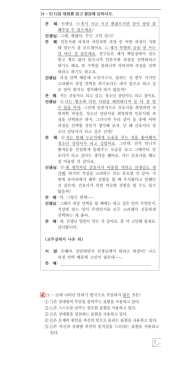

사용된 숫자 리스트: [4]
남은 숫자 리스트: [1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]


In [23]:
import cv2
import easyocr
import re
from PIL import Image
import matplotlib.pyplot as plt

# 1부터 45까지의 숫자 리스트 생성
all_numbers = list(range(1, 46))

# 이미지 파일 경로 (예시)
image_files = [
    r'C:\Users\hana9\preprocessing\kor_test\2015_G1_11_KOR\cropped\2015_G1_11_KOR_left__page1.png',
    # 다른 이미지 파일들 추가
]

# EasyOCR을 사용하여 텍스트 인식
reader = easyocr.Reader(['ko', 'en'])

# 정규 표현식으로 매칭되는 패턴들 정의
pattern1 = r'\[\d+\s*~\s*\d+\]|\[\d+~\d+\]|\[\d+\s*~\d+\]|\[\d+~\s*\d+\]'
pattern2 = r'\d+\.'
pattern3 = r'\[\d+\s*\d+\]|\[\d+\s*\]|\[\s*\d+\]'

# 각 이미지에 대해 처리
for idx, f_name in enumerate(image_files):
    # 0부터 15 페이지마다 숫자 리스트 리셋
    if idx % 16 == 0:
        all_numbers = list(range(1, 46))
    
    # EasyOCR을 사용하여 텍스트 인식
    results = reader.readtext(f_name)

    # EasyOCR에서 읽어온 전체 텍스트 추출
    full_text = ""
    for (bbox, text, prob) in results:
        full_text += text + "\n"

    # 정규 표현식으로 매칭되는 패턴 찾기
    def find_patterns(results, patterns):
        found_patterns = []
        for pattern in patterns:
            matches = re.findall(pattern, full_text)
            if matches:
                found_patterns.extend(matches)
        return found_patterns

    # 패턴 찾기
    found_patterns = find_patterns(results, [pattern1, pattern2, pattern3])

    if found_patterns:
        # 패턴 출력 (디버깅용)
        print("Found patterns:", found_patterns)

        # 이미지를 numpy 배열로 변환
        image_cv = cv2.imread(f_name)
        image_cv = cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB)

        # 각 패턴에 대해 사각형 그리기
        for match in found_patterns:
            matches_bbox = []
            for (bbox, text, prob) in results:
                if text == match:
                    start_x, start_y = bbox[0]
                    end_x, end_y = bbox[2]
                    matches_bbox.append((start_x, start_y, end_x, end_y))

            # 사각형 그리기
            for bbox in matches_bbox:
                cv2.rectangle(image_cv, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (255, 0, 0), 2)

        # 결과 이미지 출력
        plt.imshow(image_cv)
        plt.axis('off')
        plt.show()
    else:
        print("적합한 패턴을 찾지 못했습니다.")

    # 사용된 숫자 리스트 출력
    matches = re.findall(pattern2, full_text)
    used_numbers = []
    for match in matches:
        number = int(match.rstrip('.'))
        if number in all_numbers:
            all_numbers.remove(number)  # 사용된 숫자 리스트에서 제거
            used_numbers.append(number)
    
    print("사용된 숫자 리스트:", used_numbers)
    print("남은 숫자 리스트:", all_numbers)


# kor 크롭 코드

In [2]:
import cv2
import easyocr
import re, glob, os
import matplotlib.pyplot as plt

# 1부터 45까지의 숫자 리스트 생성
all_numbers = list(range(1, 46))

# 이미지 파일들이 있는 디렉토리 경로
directory = r'C:\Users\hana9\preprocessing\a_kor_test\2015_G1_11_KOR\cropped'

# 결과 이미지를 저장할 디렉토리 경로
output_directory = r'C:\Users\hana9\preprocessing\output_images_A'

# 해당 디렉토리 내의 모든 png 파일 찾기
png_files = glob.glob(os.path.join(directory, '*.png'))

def extract_sort_key(filename):
    # 파일명에서 left 또는 right 부분과 숫자 부분을 추출하여 정렬 키를 반환하는 함수
    match = re.match(r'.*_(left|right)__page(\d+)\.png', filename)
    if match:
        prefix = match.group(1)
        number = int(match.group(2))
        return (number, prefix)  # 숫자를 먼저 비교하고, 그 다음에 left/right를 비교하여 정렬

    # 매칭되지 않는 경우는 마지막으로 처리
    return (float('inf'), filename)

# 파일을 정렬합니다.
sorted_files = sorted(png_files, key=extract_sort_key)

# EasyOCR을 사용하여 텍스트 인식
reader = easyocr.Reader(['ko', 'en'])

# 정규 표현식으로 매칭되는 패턴들 정의
pattern1 = re.compile(r"\b([0-9]|[1-3][0-9]|4[0-5])\.\s*")
pattern2 = re.compile(r'^(?:\d{1,2}\s*<|\d{1,2}\s*윗글)')
pattern3 = re.compile(r'\[(\d+)\s*~\s*(\d+)\]|\[\d+\s*\b')

# 이미 사용된 숫자를 저장하는 집합
used_numbers_set = set()

# 각 이미지에 대해 처리
for idx, f_name in enumerate(sorted_files):
    # left_page0마다 숫자 리스트 리셋
    if 'left__page0' in f_name:
        all_numbers = list(range(1, 46))
    
    # EasyOCR을 사용하여 텍스트 인식
    results = reader.readtext(f_name)

    # 정규 표현식으로 매칭되는 패턴 찾기
    def find_patterns(results, patterns):
        found_patterns = []
        for pattern in patterns:
            for (bbox, text, prob) in results:
                if re.match(pattern, text):
                    found_patterns.append((bbox, text, prob))
        return found_patterns

    # 패턴 찾기
    found_patterns = find_patterns(results, [pattern1, pattern2, pattern3])

    if found_patterns:
        # 패턴 출력 (디버깅용)
        print("Found patterns:", found_patterns)

        # 이미지를 numpy 배열로 변환
        image_cv = cv2.imread(f_name)
        # image_cv = cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB)

        # 패턴이 있는 텍스트의 bbox 찾기
        pattern_bboxes = []
        for pattern in found_patterns:
            for (bbox, text, prob) in results:
                if re.match(pattern, text):
                    pattern_bboxes.append(bbox)

        # 각 바운딩 박스 좌표 출력 (디버깅용)
        for bbox in pattern_bboxes:
            print(f"BBox coordinates: {bbox}")

        # y 좌표로 정렬
        pattern_bboxes.sort(key=lambda b: b[0][1])

        
        # 첫 번째 패턴의 bbox를 시작점으로 설정
        if pattern_bboxes:
            start_x = 0  # 이미지의 왼쪽 끝부터 시작
            start_y = 0
            # start_y = int(pattern_bboxes[0][0][1])

            i = 0
            # 첫 번째 패턴 전까지 자르기 또는 첫 번째 패턴부터 다음 패턴까지 자르기
            if len(pattern_bboxes) > 0:
                first_bbox = pattern_bboxes[0]
                first_pattern_y = int(first_bbox[0][1])
                
                if first_pattern_y <= 30:  # 첫 패턴이 이미지 시작 부분에 가깝다면
                    # 첫 번째 패턴부터 다음 패턴까지 크롭
                    print(f"First pattern is close to the top of the image at y={first_pattern_y}.")
                else:
                    # 0부터 첫 번째 패턴 전까지 크롭
                    end_x = image_cv.shape[1]
                    end_y = first_pattern_y

                    # y 좌표와 x 좌표를 확인 (디버깅용)
                    print(f"Cropping from start: start_y={start_y}, end_y={end_y}, start_x={start_x}, end_x={end_x}")

                    try:
                        # 유효성 검사
                        if start_y < end_y:
                            # 이미지 crop
                            cropped_image = image_cv[start_y:end_y, start_x:end_x]

                            # 결과 이미지 저장
                            filename = os.path.basename(f_name)
                            save_path = os.path.join(output_directory, f"{filename}_cropped_{idx}_start.png")
                            cv2.imwrite(save_path, cropped_image)

                            # 사용된 숫자 집합에 추가
                            # pattern_text = found_patterns[i]
                            matches = re.findall(pattern2, pattern_text)
                            for match in matches:
                                number = int(match.rstrip('.?'))
                                used_numbers_set.add(number)
                        else:
                            print(f"Invalid crop dimensions for first crop: start_y={start_y}, end_y={end_y}, start_x={start_x}, end_x={end_x}")
                    except ValueError as e:
                        print(f"Error occurred in first crop: {e}")
                        print(f"Skipping invalid crop dimensions for first crop: start_y={start_y}, end_y={end_y}, start_x={start_x}, end_x={end_x}")

                    start_y = end_y  # 첫 번째 패턴 끝난 지점부터 다음 크롭 시작

            while i < len(pattern_bboxes):
                # 현재 패턴의 bbox 설정
                current_bbox = pattern_bboxes[i]
                end_x = image_cv.shape[1]  # 이미지의 가로 길이

                # 현재 패턴의 bbox 설정
                current_bbox = pattern_bboxes[i]
                end_x = image_cv.shape[1]  # 이미지의 가로 길이
                if i < len(pattern_bboxes) - 1:  # 다음 bbox가 존재하면
                    next_bbox = pattern_bboxes[i + 1]
                    end_y = int(next_bbox[0][1])  # 다음 패턴의 시작 y좌표
                else:
                    end_y = image_cv.shape[0] # 다음 패턴이 없는 경우 이미지의 끝에서 315픽셀 위까지
                
                # Check if the index is within the valid range
                if 0 <= i < len(found_patterns):
                # 패턴에 숫자가 포함되어 있고, 이미 사용된 숫자인지 확인
                    pattern_text = found_patterns[i]
                    matches = re.findall(pattern2, pattern_text)
                    should_skip = False
                    for match in matches:
                        number = int(match.rstrip('.'))
                        if number in used_numbers_set or number not in all_numbers:
                            should_skip = True
                            break
                else:
                    print(f"Index out of range: {i} is not within the valid range of found_patterns.")
                    break

                if should_skip:
                    print(f"Skipping crop for pattern '{pattern_text}' because it contains already used number.")
                    i += 1
                    continue

                # y 좌표와 x 좌표를 확인 (디버깅용)
                print(f"Cropping: start_y={start_y}, end_y={end_y}, start_x={start_x}, end_x={end_x}")

                try:
                    # 유효성 검사
                    if start_y < end_y:
                        # 이미지 crop
                        cropped_image = image_cv[start_y:end_y, start_x:end_x]

                        # 결과 이미지 저장
                        filename = os.path.basename(f_name)
                        save_path = os.path.join(output_directory, f"{filename}_cropped_{idx}_{i}.png")
                        cv2.imwrite(save_path, cropped_image)

                        # 사용된 숫자 집합에 추가
                        matches = re.findall(pattern2, pattern_text)
                        for match in matches:
                            number = int(match.rstrip('.'))
                            used_numbers_set.add(number)
                    else:
                        print(f"Invalid crop dimensions: start_y={start_y}, end_y={end_y}, start_x={start_x}, end_x={end_x}")
                        # start_y 조정
                        start_y = int(pattern_bboxes[0][0][0] - 215)
                        if start_y < end_y:
                            # 이미지 crop
                            cropped_image = image_cv[start_y:end_y, start_x:end_x]

                            # 사각형 그리기 (디버깅용)
                            # cv2.rectangle(image_cv, (start_x, start_y), (end_x, end_y), (255, 0, 0), 2)

                            # 결과 이미지 저장
                            filename = os.path.basename(f_name)
                            save_path = os.path.join(output_directory, f"{filename}_cropped_{idx}_{i}.png")
                            cv2.imwrite(save_path, cropped_image)

                            # 사용된 숫자 집합에 추가
                            matches = re.findall(pattern2, pattern_text)
                            for match in matches:
                                number = int(match.rstrip('.'))
                                used_numbers_set.add(number)
                        else:
                            print(f"Adjusted invalid crop dimensions: start_y={start_y}, end_y={end_y}, start_x={start_x}, end_x={end_x}")
                except ValueError as e:
                    print(f"Error occurred: {e}")
                    print(f"Skipping invalid crop dimensions: start_y={start_y}, end_y={end_y}, start_x={start_x}, end_x={end_x}")
                    i+=1
                    continue
            
                # 다음 패턴의 시작점으로 설정
                start_y = end_y
                i += 1

    else:
        print("적합한 패턴을 찾지 못했습니다.")

    # 사용된 숫자 리스트 출력
    matches = re.findall(pattern2, full_text)
    used_numbers = []
    for match in matches:
        number = int(match.rstrip('.'))
        if number in all_numbers:
            all_numbers.remove(number)  # 사용된 숫자 리스트에서 제거
            used_numbers.append(number)
    
    print("사용된 숫자 리스트:", used_numbers)
    print("남은 숫자 리스트:", all_numbers)

# 모든 이미지 처리 완료 후에 남은 숫자 리스트 출력 및 파일로 저장
remaining_numbers = sorted(all_numbers)

print("Remaining numbers list:", remaining_numbers)

# 결과 텍스트 파일에 남은 숫자 리스트 저장
result_filename = "remaining_numbers.txt"
result_filepath = os.path.join(output_directory, result_filename)

with open(result_filepath, 'w') as f:
    for num in remaining_numbers:
        f.write(f"{num}\n")

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Found patterns: [([[232, 27], [265, 27], [265, 65], [232, 65]], '[1', 0.9999710030913613)]


TypeError: unhashable type: 'list'

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


[([[235, 21], [288, 21], [288, 61], [235, 61]], '27.', 0.7434664644734382),
 ([[438, 20], [912, 20], [912, 68], [438, 68]],
  '사전적 의미로 적절하지 않은 것은?',
  0.9575997416049478),
 ([[348, 71], [899, 71], [899, 120], [348, 120]],
  '어떤 내용이 구체적인 사실로 나타나게 함:',
  0.826513524647615),
 ([[346, 118], [776, 118], [776, 166], [346, 166]],
  '성짙이나 종류에 따라 차이가 남.',
  0.4356375925003723),
 ([[349, 168], [744, 168], [744, 212], [349, 212]],
  '관심올 가지고 주의 깊게 살필.',
  0.37149589679845135),
 ([[346, 212], [734, 212], [734, 263], [346, 263]],
  '알맞게 이용하거나 맞추어 솜.',
  0.914764762473879),
 ([[347, 264], [782, 264], [782, 308], [347, 308]],
  '있어야 할 것올 빠짐없이 다 갖춤.',
  0.6849103184732758),
 ([[231, 414], [288, 414], [288, 454], [231, 454]], '[28', 0.9999903644340618),
 ([[309, 412], [795, 412], [795, 457], [309, 457]],
  '30] 다음 글을 읽고 물음에 답하시오.',
  0.3397227442602016),
 ([[286, 491], [1129, 491], [1129, 539], [286, 539]],
  '뼈는   우리   몸올   지지하고   심장이나  뇌   등의   주요   장기름   보',
  0.602379864189146),
 ([[258, 541], [112

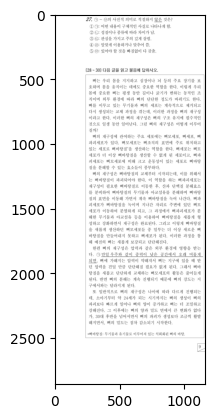

In [45]:
from matplotlib.pyplot import imshow
from PIL import Image

f_name = r'C:\Users\hana9\preprocessing\a_kor_test\2015_G1_11_KOR\cropped\2015_G1_11_KOR_left__page8.png'

%matplotlib inline
pil_im = Image.open(f_name, 'r')
imshow(pil_im)

import easyocr

# easy-ocr
reader = easyocr.Reader(['ko','en'])
txt = reader.readtext(f_name)
txt

# eng 코드

In [81]:
import cv2
import easyocr
import re, glob, os
import matplotlib.pyplot as plt

# 1부터 45까지의 숫자 리스트 생성
all_numbers = list(range(1, 46))

# 이미지 파일들이 있는 디렉토리 경로
directory = r'C:\Users\hana9\preprocessing\a_eng_test\2015_G1_11_ENG\cropped'

# 결과 이미지를 저장할 디렉토리 경로
output_directory = r'C:\Users\hana9\preprocessing\output_images_eng'

# 해당 디렉토리 내의 모든 png 파일 찾기
png_files = glob.glob(os.path.join(directory, '*.png'))

def extract_sort_key(filename):
    # 파일명에서 left 또는 right 부분과 숫자 부분을 추출하여 정렬 키를 반환하는 함수
    match = re.match(r'.*_(left|right)__page(\d+)\.png', filename)
    if match:
        prefix = match.group(1)
        number = int(match.group(2))
        return (number, prefix)  # 숫자를 먼저 비교하고, 그 다음에 left/right를 비교하여 정렬

    # 매칭되지 않는 경우는 마지막으로 처리
    return (float('inf'), filename)

# 파일을 정렬합니다.
sorted_files = sorted(png_files, key=extract_sort_key)

# EasyOCR을 사용하여 텍스트 인식
reader = easyocr.Reader(['ko', 'en'])

# 정규 표현식으로 매칭되는 패턴들 정의
pattern1 = re.compile(r"\b([0-9]|[1-3][0-9]|4[0-5])\.\s*")
pattern2 = re.compile(r'\d{1,2}\s*대화')
pattern3 = re.compile(r'\[(\d+)\s*~\s*(\d+)\]|\[\d+\s*\b|\[\d+\s*\b\]?$')

# 이미 사용된 숫자를 저장하는 집합
used_numbers_set = set()

# 각 이미지에 대해 처리
for idx, f_name in enumerate(sorted_files):
    # left_page0마다 숫자 리스트 리셋
    if 'left__page0' in f_name:
        all_numbers = list(range(1, 46))
    
    # EasyOCR을 사용하여 텍스트 인식
    results = reader.readtext(f_name)

    # EasyOCR에서 읽어온 전체 텍스트 추출
    full_text = "\n".join([result[1] for result in results])

    # 정규 표현식으로 매칭되는 패턴 찾기
    def find_patterns(results, patterns):
        found_patterns = []
        for pattern in patterns:
            matches = re.findall(pattern, full_text)
            if matches:
                found_patterns.extend(matches)
        # 중복된 패턴 제거
        found_patterns = list(dict.fromkeys(found_patterns))
        return found_patterns

    # 패턴 찾기
    found_patterns = find_patterns(results, [pattern1, pattern2, pattern3])

    if found_patterns:
        # 패턴 출력 (디버깅용)
        print("Found patterns:", found_patterns)

        # 이미지를 numpy 배열로 변환
        image_cv = cv2.imread(f_name)
        # image_cv = cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB)

        # 패턴이 있는 텍스트의 bbox 찾기
        pattern_bboxes = []
        for pattern in found_patterns:
            for (bbox, text, prob) in results:
                if re.match(pattern, text):
                    pattern_bboxes.append(bbox)

        # 각 바운딩 박스 좌표 출력 (디버깅용)
        for bbox in pattern_bboxes:
            print(f"BBox coordinates: {bbox}")

        # y 좌표로 정렬
        pattern_bboxes.sort(key=lambda b: b[0][1])

        
        # 첫 번째 패턴의 bbox를 시작점으로 설정
        if pattern_bboxes:
            start_x = 0  # 이미지의 왼쪽 끝부터 시작
            start_y = 0
            # start_y = int(pattern_bboxes[0][0][1])

            i = 0
            # 첫 번째 패턴 전까지 자르기 또는 첫 번째 패턴부터 다음 패턴까지 자르기
            if len(pattern_bboxes) > 0:
                first_bbox = pattern_bboxes[0]
                first_pattern_y = int(first_bbox[0][1])
                
                if first_pattern_y <= 30:  # 첫 패턴이 이미지 시작 부분에 가깝다면
                    # 첫 번째 패턴부터 다음 패턴까지 크롭
                    print(f"First pattern is close to the top of the image at y={first_pattern_y}.")
                else:
                    # 0부터 첫 번째 패턴 전까지 크롭
                    end_x = image_cv.shape[1]
                    end_y = first_pattern_y

                    # y 좌표와 x 좌표를 확인 (디버깅용)
                    print(f"Cropping from start: start_y={start_y}, end_y={end_y}, start_x={start_x}, end_x={end_x}")

                    try:
                        # 유효성 검사
                        if start_y < end_y:
                            # 이미지 crop
                            cropped_image = image_cv[start_y:end_y, start_x:end_x]

                            # 결과 이미지 저장
                            filename = os.path.basename(f_name)
                            save_path = os.path.join(output_directory, f"{filename}_cropped_{idx}_start.png")
                            cv2.imwrite(save_path, cropped_image)

                            # 사용된 숫자 집합에 추가
                            # pattern_text = found_patterns[i]
                            matches = re.findall(pattern2, pattern_text)
                            for match in matches:
                                number = int(match.rstrip('.?'))
                                used_numbers_set.add(number)
                        else:
                            print(f"Invalid crop dimensions for first crop: start_y={start_y}, end_y={end_y}, start_x={start_x}, end_x={end_x}")
                    except ValueError as e:
                        print(f"Error occurred in first crop: {e}")
                        print(f"Skipping invalid crop dimensions for first crop: start_y={start_y}, end_y={end_y}, start_x={start_x}, end_x={end_x}")

                    start_y = end_y  # 첫 번째 패턴 끝난 지점부터 다음 크롭 시작

            while i < len(pattern_bboxes):
                # 현재 패턴의 bbox 설정
                current_bbox = pattern_bboxes[i]
                end_x = image_cv.shape[1]  # 이미지의 가로 길이

                # 현재 패턴의 bbox 설정
                current_bbox = pattern_bboxes[i]
                end_x = image_cv.shape[1]  # 이미지의 가로 길이
                if i < len(pattern_bboxes) - 1:  # 다음 bbox가 존재하면
                    next_bbox = pattern_bboxes[i + 1]
                    end_y = int(next_bbox[0][1])  # 다음 패턴의 시작 y좌표
                else:
                    end_y = image_cv.shape[0] # 다음 패턴이 없는 경우 이미지의 끝에서 315픽셀 위까지
                
                # Check if the index is within the valid range
                if 0 <= i < len(found_patterns):
                # 패턴에 숫자가 포함되어 있고, 이미 사용된 숫자인지 확인
                    pattern_text = found_patterns[i]
                    matches = re.findall(pattern2, pattern_text)
                    should_skip = False
                    for match in matches:
                        number = int(match.rstrip('.'))
                        if number not in all_numbers:
                            should_skip = True
                            break
                else:
                    print(f"Index out of range: {i} is not within the valid range of found_patterns.")
                    break

                if should_skip:
                    print(f"Skipping crop for pattern '{pattern_text}' because it contains already used number.")
                    i += 1
                    continue

                # y 좌표와 x 좌표를 확인 (디버깅용)
                print(f"Cropping: start_y={start_y}, end_y={end_y}, start_x={start_x}, end_x={end_x}")

                try:
                    # 유효성 검사
                    if start_y < end_y:
                        # 이미지 crop
                        cropped_image = image_cv[start_y:end_y, start_x:end_x]

                        # 결과 이미지 저장
                        filename = os.path.basename(f_name)
                        save_path = os.path.join(output_directory, f"{filename}_cropped_{idx}_{i}.png")
                        cv2.imwrite(save_path, cropped_image)

                        # 사용된 숫자 집합에 추가
                        matches = re.findall(pattern2, pattern_text)
                        for match in matches:
                            number = int(match.rstrip('.'))
                            used_numbers_set.add(number)
                    else:
                        print(f"Invalid crop dimensions: start_y={start_y}, end_y={end_y}, start_x={start_x}, end_x={end_x}")
                        # start_y 조정
                        start_y = int(pattern_bboxes[0][0][0])
                        if start_y < end_y:
                            # 이미지 crop
                            cropped_image = image_cv[start_y:end_y, start_x:end_x]

                            # 사각형 그리기 (디버깅용)
                            # cv2.rectangle(image_cv, (start_x, start_y), (end_x, end_y), (255, 0, 0), 2)

                            # 결과 이미지 저장
                            filename = os.path.basename(f_name)
                            save_path = os.path.join(output_directory, f"{filename}_cropped_{idx}_{i}.png")
                            cv2.imwrite(save_path, cropped_image)

                            # 사용된 숫자 집합에 추가
                            matches = re.findall(pattern2, pattern_text)
                            for match in matches:
                                number = int(match.rstrip('.'))
                                used_numbers_set.add(number)
                        else:
                            print(f"Adjusted invalid crop dimensions: start_y={start_y}, end_y={end_y}, start_x={start_x}, end_x={end_x}")
                except ValueError as e:
                    print(f"Error occurred: {e}")
                    print(f"Skipping invalid crop dimensions: start_y={start_y}, end_y={end_y}, start_x={start_x}, end_x={end_x}")
                    i+=1
                    continue
            
                # 다음 패턴의 시작점으로 설정
                start_y = end_y
                i += 1

    else:
        print("적합한 패턴을 찾지 못했습니다.")

    # 사용된 숫자 리스트 출력
    matches = re.findall(pattern2, full_text)
    used_numbers = []
    for match in matches:
        number = int(match.rstrip('.'))
        if number in all_numbers:
            all_numbers.remove(number)  # 사용된 숫자 리스트에서 제거
            used_numbers.append(number)
    
    print("사용된 숫자 리스트:", used_numbers)
    print("남은 숫자 리스트:", all_numbers)

# 모든 이미지 처리 완료 후에 남은 숫자 리스트 출력 및 파일로 저장
remaining_numbers = sorted(all_numbers)

print("Remaining numbers list:", remaining_numbers)

# 결과 텍스트 파일에 남은 숫자 리스트 저장
result_filename = "remaining_numbers.txt"
result_filepath = os.path.join(output_directory, result_filename)

with open(result_filepath, 'w') as f:
    for num in remaining_numbers:
        f.write(f"{num}\n")

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Found patterns: ['1', '2', '3', '4', '5']
BBox coordinates: [[270, 54], [1106, 54], [1106, 104], [270, 104]]
BBox coordinates: [[237, 305], [1153, 305], [1153, 349], [237, 349]]
BBox coordinates: [[237, 801], [1153, 801], [1153, 845], [237, 845]]
BBox coordinates: [[237, 1294], [1139, 1294], [1139, 1338], [237, 1338]]
BBox coordinates: [[236, 1739], [1042, 1739], [1042, 1789], [236, 1789]]
BBox coordinates: [[237, 2192], [1087, 2192], [1087, 2236], [237, 2236]]
Cropping from start: start_y=0, end_y=54, start_x=0, end_x=1164
Cropping: start_y=54, end_y=305, start_x=0, end_x=1164
Cropping: start_y=305, end_y=801, start_x=0, end_x=1164
Cropping: start_y=801, end_y=1294, start_x=0, end_x=1164
Cropping: start_y=1294, end_y=1739, start_x=0, end_x=1164
Cropping: start_y=1739, end_y=2192, start_x=0, end_x=1164
Index out of range: 5 is not within the valid range of found_patterns.
사용된 숫자 리스트: []
남은 숫자 리스트: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 2

ValueError: invalid literal for int() with base 10: '7 대화'

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


[([[14, 21], [67, 21], [67, 61], [14, 61]], '39', 0.9998941287580946),
 ([[69, 111], [345, 111], [345, 144], [69, 144]],
  'That may seem like',
  0.9328011745143718),
 ([[372, 108], [907, 108], [907, 148], [372, 148]],
  'lot until you consider that the average',
  0.9417687437512726),
 ([[63, 155], [907, 155], [907, 198], [63, 198]],
  'native living in the Amazonas of Venezuela has roughly 1,600',
  0.5591906057013576),
 ([[66, 204], [413, 204], [413, 244], [66, 244]],
  'species, a full third more',
  0.9750557360842057),
 ([[70, 276], [916, 276], [916, 319], [70, 319]],
  'Clearly there is no shortage of bacteria in our gut, which can',
  0.7530585675130673),
 ([[41, 325], [407, 325], [407, 362], [41, 362]],
  'make this next statement',
  0.6891920941642175),
 ([[441, 325], [746, 325], [746, 362], [441, 362]],
  'little hard to believe.',
  0.5192276025173173),
 ([[862, 328], [917, 328], [917, 361], [862, 361]], 'Our', 0.999670057772387),
 ([[95, 371], [750, 371], [750, 415], [95

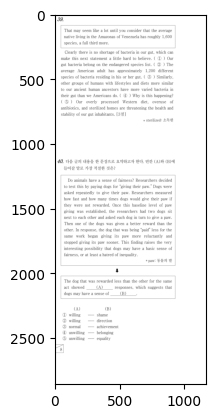

In [98]:
from matplotlib.pyplot import imshow
from PIL import Image

f_name = r'C:\Users\hana9\preprocessing\a_eng_test\2015_G1_11_ENG\cropped\2015_G1_11_ENG_right__page6.png'

%matplotlib inline
pil_im = Image.open(f_name, 'r')
imshow(pil_im)

import easyocr

# easy-ocr
reader = easyocr.Reader(['ko','en'])
txt = reader.readtext(f_name)
txt

In [80]:
import cv2
import easyocr
import re
import glob
import os

# 1부터 45까지의 숫자 리스트 생성
all_numbers = list(range(1, 46))

# 이미지 파일들이 있는 디렉토리 경로
directory = r'C:\Users\hana9\preprocessing\a_eng_test\2015_G1_11_ENG\cropped'

# 결과 이미지를 저장할 디렉토리 경로
output_directory = r'C:\Users\hana9\preprocessing\output_images_eng'

# 해당 디렉토리 내의 모든 png 파일 찾기
png_files = glob.glob(os.path.join(directory, '*.png'))

def extract_sort_key(filename):
    # 파일명에서 left 또는 right 부분과 숫자 부분을 추출하여 정렬 키를 반환하는 함수
    match = re.match(r'.*_(left|right)__page(\d+)\.png', filename)
    if match:
        prefix = match.group(1)
        number = int(match.group(2))
        return (number, prefix)  # 숫자를 먼저 비교하고, 그 다음에 left/right를 비교하여 정렬

    # 매칭되지 않는 경우는 마지막으로 처리
    return (float('inf'), filename)

# 파일을 정렬합니다.
sorted_files = sorted(png_files, key=extract_sort_key)

# EasyOCR을 사용하여 텍스트 인식
reader = easyocr.Reader(['ko', 'en'])

# 정규 표현식으로 매칭되는 패턴들 정의
pattern1 = re.compile(r"\b([0-9]|[1-3][0-9]|4[0-5])\.\s*")
pattern2 = re.compile(r'\d{1,2}\s*대화')
pattern3 = re.compile(r'\[(\d+)\s*~\s*(\d+)\]|\[\d+\s*\b|\[\d+\s*\b\]?$')

# 이미 사용된 숫자를 저장하는 집합
used_numbers_set = set()

# 각 이미지에 대해 처리
for idx, f_name in enumerate(sorted_files):
    # left_page0마다 숫자 리스트 리셋
    if 'left__page0' in f_name:
        all_numbers = list(range(1, 46))
    
    # EasyOCR을 사용하여 텍스트 인식
    results = reader.readtext(f_name)

    # EasyOCR에서 읽어온 전체 텍스트 추출
    full_text = "\n".join([result[1] for result in results])

    # 정규 표현식으로 매칭되는 패턴 찾기
    def find_patterns(results, patterns):
        found_patterns = []
        for pattern in patterns:
            matches = re.findall(pattern, full_text)
            if matches:
                found_patterns.extend(matches)
        # 중복된 패턴 제거
        found_patterns = list(dict.fromkeys(found_patterns))
        return found_patterns

    # 패턴 찾기
    found_patterns = find_patterns(results, [pattern1, pattern2, pattern3])

    if found_patterns:
        # 패턴 출력 (디버깅용)
        print("Found patterns:", found_patterns)

        # 이미지를 numpy 배열로 변환
        image_cv = cv2.imread(f_name)
        # image_cv = cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB)

        # 패턴이 있는 텍스트의 bbox 찾기
        pattern_bboxes = []
        for pattern in found_patterns:
            for (bbox, text, prob) in results:
                if re.match(pattern, text):
                    pattern_bboxes.append(bbox)

        # 각 바운딩 박스 좌표 출력 (디버깅용)
        for bbox in pattern_bboxes:
            print(f"BBox coordinates: {bbox}")
            # bbox 시각화
            cv2.rectangle(image_cv, (bbox[0][0], bbox[0][1]), (bbox[2][0], bbox[2][1]), (0, 255, 0), 2)  # 초록색 사각형
        
        # 시각화된 이미지를 저장할 경로 설정
        filename = os.path.basename(f_name)
        vis_save_path = os.path.join(output_directory, f"{filename}_visualized.png")

        # 시각화된 이미지 저장
        cv2.imwrite(vis_save_path, image_cv)
        
        # y 좌표로 정렬
        pattern_bboxes.sort(key=lambda b: b[0][1])

        # 첫 번째 패턴의 bbox를 시작점으로 설정
        if pattern_bboxes:
            start_x = 0  # 이미지의 왼쪽 끝부터 시작
            start_y = 0

            # 반복해서 패턴을 찾아서 잘라냅니다.
            for i, bbox in enumerate(pattern_bboxes):
                top_left = (bbox[0][0], bbox[0][1])  # 좌측 상단 점의 좌표 (x, y)
                bottom_right = (bbox[2][0], bbox[2][1])  # 우측 하단 점의 좌표 (x, y)
                
                # 다음 패턴의 bbox 찾기
                if i + 1 < len(pattern_bboxes):
                    next_bbox = pattern_bboxes[i + 1]
                    next_top_left = (next_bbox[0][0], next_bbox[0][1])  # 다음 패턴의 좌측 상단 점의 좌표 (x, y)
                    end_y = next_top_left[1]  # 다음 패턴의 상단부까지 자르기
                else:
                    # 마지막 패턴인 경우 이미지의 하단까지 자르기
                    end_y = image_cv.shape[0]

                # 이미지 자르기
                cropped_image = image_cv[top_left[1]:end_y, start_x:image_cv.shape[1]]

                 # 잘린 이미지가 비어 있는지 확인
                if cropped_image is None or cropped_image.size == 0:
                    print(f"Skipping empty cropped image for pattern '{pattern_text}'")
                    continue

                # 결과 이미지 저장
                filename = os.path.basename(f_name)
                save_path = os.path.join(output_directory, f"{filename}_cropped_{idx}_{i}.png")

                # 이미지를 저장하기 전에 빈 이미지인지 확인
                if not cropped_image.any():  # 이미지가 비어 있으면
                    print(f"Skipping saving empty image to {save_path}")
                    continue
                cv2.imwrite(save_path, cropped_image)

                # Check if the index is within the valid range
                if 0 <= i < len(found_patterns):
                # 패턴에 숫자가 포함되어 있고, 이미 사용된 숫자인지 확인
                    pattern_text = found_patterns[i]
                    matches = re.findall(pattern2, pattern_text)
                    should_skip = False
                    for match in matches:
                        number = match.rstrip('. ').split()[0]
                        used_numbers_set.add(number)
                        if number not in all_numbers:
                            should_skip = True
                            break

                else:
                    print(f"Index out of range: {i} is not within the valid range of found_patterns.")
                    break

                if should_skip:
                    print(f"Skipping crop for pattern '{pattern_text}' because it contains already used number.")
                    i += 1
                    continue

                # y 좌표와 x 좌표를 확인 (디버깅용)
                print(f"Cropping: start_y={start_y}, end_y={end_y}, start_x={start_x}, end_x={end_x}")


                # # 사용된 숫자 집합에 추가
                # pattern_text = found_patterns[i]
                # matches = re.findall(pattern2, pattern_text)
                # for match in matches:
                #     number = int(match.rstrip('.'))
                #     used_numbers_set.add(number)

                # print(f"Image cropped and saved to {save_path}")

            start_y = bottom_right[1]  # 다음 패턴을 자를 시작점으로 설정

    # 사용된 숫자 리스트 출력
    matches = re.findall(pattern2, full_text)
    used_numbers = []
    for match in matches:
        number = match.rstrip('. ').split()[0]
        if number in all_numbers:
            all_numbers.remove(number)  # 사용된 숫자 리스트에서 제거
            used_numbers.append(number)
    
    print("사용된 숫자 리스트:", used_numbers)
    print("남은 숫자 리스트:", all_numbers)


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Found patterns: ['1', '2', '3', '4', '5']
BBox coordinates: [[270, 54], [1106, 54], [1106, 104], [270, 104]]
BBox coordinates: [[237, 305], [1153, 305], [1153, 349], [237, 349]]
BBox coordinates: [[237, 801], [1153, 801], [1153, 845], [237, 845]]
BBox coordinates: [[237, 1294], [1139, 1294], [1139, 1338], [237, 1338]]
BBox coordinates: [[236, 1739], [1042, 1739], [1042, 1789], [236, 1789]]
BBox coordinates: [[237, 2192], [1087, 2192], [1087, 2236], [237, 2236]]
Cropping: start_y=0, end_y=305, start_x=0, end_x=1142
Cropping: start_y=0, end_y=801, start_x=0, end_x=1142
Cropping: start_y=0, end_y=1294, start_x=0, end_x=1142
Cropping: start_y=0, end_y=1739, start_x=0, end_x=1142
Cropping: start_y=0, end_y=2192, start_x=0, end_x=1142
Index out of range: 5 is not within the valid range of found_patterns.
사용된 숫자 리스트: []
남은 숫자 리스트: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 

KeyboardInterrupt: 

In [79]:
import cv2
import easyocr
import re
import glob
import os

# 이미지 파일들이 있는 디렉토리 경로
directory = r'C:\Users\hana9\preprocessing\a_eng_test\2015_G1_11_ENG\cropped'

# 결과 이미지를 저장할 디렉토리 경로
output_directory = r'C:\Users\hana9\preprocessing\output_images_eng'

# 해당 디렉토리 내의 모든 png 파일 찾기
png_files = glob.glob(os.path.join(directory, '*.png'))

# EasyOCR을 사용하여 텍스트 인식
reader = easyocr.Reader(['ko', 'en'])

# 정규 표현식으로 매칭되는 패턴들 정의
pattern1 = re.compile(r"\b([0-9]|[1-3][0-9]|4[0-5])\.\s*")
pattern2 = re.compile(r'\d{1,2}\s*대화')
pattern3 = re.compile(r'\[(\d+)\s*~\s*(\d+)\]|\[\d+\s*\b|\[\d+\s*\b\]?$')

patterns = [pattern1, pattern2, pattern3]

# 각 이미지에 대해 처리
for idx, f_name in enumerate(png_files):
    # 이미지 파일 읽기
    img = cv2.imread(f_name)

    # EasyOCR을 사용하여 텍스트 인식
    results = reader.readtext(f_name)

    # 정규 표현식으로 매칭되는 패턴 찾기
    def find_patterns(results, patterns):
        found_patterns = []
        for pattern in patterns:
            for (bbox, text, prob) in results:
                if re.match(pattern, text):
                    found_patterns.append((bbox, text, prob))
        return found_patterns

    # 패턴 찾기
    found_patterns = find_patterns(results, patterns)

    if found_patterns:
        # 패턴 출력 (디버깅용)
        print("Found patterns:", found_patterns)

        # 패턴이 있는 텍스트의 내용과 위치 정보를 활용하여 처리
        for (bbox, text, prob) in found_patterns:
            print(f"Pattern found at bbox {bbox}: {text}")

    # 추가적인 처리나 저장 코드를 여기에 추가할 수 있습니다.


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Found patterns: [([[237, 305], [1153, 305], [1153, 349], [237, 349]], '1. 대화틀 듣고 남자의 마지막 말에 대한 여자의 응답으로 가장 적절한', 0.41740339820679806), ([[237, 801], [1153, 801], [1153, 845], [237, 845]], '2. 대화틀 듣고 여자의 마지막 말에 대한 남자의 응답으로 가장 적절한', 0.5802337998495376), ([[237, 1294], [1139, 1294], [1139, 1338], [237, 1338]], '3. 다음올 듣고 여자가 하는 말의 목적으로 가장 적절한 것올 고르시오', 0.32069111035063286), ([[236, 1739], [1042, 1739], [1042, 1789], [236, 1789]], '4. 대화틀 듣고 여자의 의견으로 가장 적절한 것올 고르시오.', 0.3482642817253763), ([[237, 2192], [1087, 2192], [1087, 2236], [237, 2236]], '5. 대화틀 듣고 두 사람의 관계름 가장 잘 나타번 것올 고르시오', 0.281114620977647)]
Pattern found at bbox [[237, 305], [1153, 305], [1153, 349], [237, 349]]: 1. 대화틀 듣고 남자의 마지막 말에 대한 여자의 응답으로 가장 적절한
Pattern found at bbox [[237, 801], [1153, 801], [1153, 845], [237, 845]]: 2. 대화틀 듣고 여자의 마지막 말에 대한 남자의 응답으로 가장 적절한
Pattern found at bbox [[237, 1294], [1139, 1294], [1139, 1338], [237, 1338]]: 3. 다음올 듣고 여자가 하는 말의 목적으로 가장 적절한 것올 고르시오
Pattern found at bbox [[236, 1739], [1042, 1739

In [104]:
import cv2
import easyocr
import re
import glob
import os

# 이미지 파일들이 있는 디렉토리 경로
directory = r'C:\Users\hana9\preprocessing\a_eng_test\2015_G1_11_ENG\cropped'

# 결과 이미지를 저장할 디렉토리 경로
output_directory = r'C:\Users\hana9\preprocessing\output_images_eng_test'

# 해당 디렉토리 내의 모든 png 파일 찾기
png_files = glob.glob(os.path.join(directory, '*.png'))

# EasyOCR을 사용하여 텍스트 인식
reader = easyocr.Reader(['ko', 'en'])

# 정규 표현식으로 매칭되는 패턴들 정의
pattern1 = re.compile(r"\b([0-9]|[1-3][0-9]|4[0-5])\.\s*")
pattern2 = re.compile(r'\d{1,2}\s*대화|\d{1,2}\n\밑줄|\d{1,2}\n\다음')
pattern3 = re.compile(r'\[(\d+)\s*~\s*(\d+)\]|\[\d+\s*\b')

patterns = [pattern1, pattern2, pattern3]

# 각 이미지에 대해 처리
for idx, f_name in enumerate(png_files):
    # 이미지 파일 읽기
    img = cv2.imread(f_name)

    # EasyOCR을 사용하여 텍스트 인식
    results = reader.readtext(f_name)

    # 정규 표현식으로 매칭되는 패턴 찾기
    def find_patterns(results, patterns):
        found_patterns = []
        for pattern in patterns:
            for (bbox, text, prob) in results:
                if re.match(pattern, text):
                    found_patterns.append((bbox, text, prob))
        return found_patterns

    # 패턴 찾기
    found_patterns = find_patterns(results, patterns)

    if found_patterns:
        # 패턴 출력 (디버깅용)
        print("Found patterns:", found_patterns)

        # y 좌표로 정렬
        found_patterns.sort(key=lambda b: b[0][0][1])

        # 정렬된 결과 출력
        print("Sorted patterns by y-coordinate:")
        for pattern in found_patterns:
            print(pattern)

        # 첫 번째 패턴의 상단 y 좌표 구하기
        first_y_min = int(found_patterns[0][0][0][1])

        # 첫 번째 패턴이 y=0 또는 y=10 근처에서 발견되지 않으면, 원본 이미지의 상단부터 다음 패턴까지 자르기
        if first_y_min > 20:
            cropped_img = img[0:first_y_min, :]

            # 결과 이미지 저장
            output_file = os.path.join(output_directory, f"{idx}_top_to_first.png")
            cv2.imwrite(output_file, cropped_img)

        # 패턴이 있는 텍스트의 내용과 위치 정보를 활용하여 처리
        for i in range(len(found_patterns) - 1):
            bbox1, text1, _ = found_patterns[i]
            bbox2, text2, _ = found_patterns[i + 1]

            # 첫 번째 패턴의 상단과 두 번째 패턴의 상단 사이의 이미지 부분 자르기
            x_min = min(int(bbox1[0][0]), int(bbox2[0][0]))
            y_min = min(int(bbox1[0][1]), int(bbox2[0][1]))
            x_max = max(int(bbox1[2][0]), int(bbox2[2][0]))
            y_max = max(int(bbox1[0][1]), int(bbox2[0][1]))

            cropped_img = img[y_min:y_max, x_min:]

            # 결과 이미지 저장
            output_file = os.path.join(output_directory, f"{idx}_{i}.png")
            cv2.imwrite(output_file, cropped_img)

        # 마지막 패턴의 상단부터 원본 이미지의 끝까지 자르기
        last_bbox, last_text, _ = found_patterns[-1]
        x_min, y_min = int(last_bbox[0][0]), int(last_bbox[0][1])
        cropped_img = img[y_min:, x_min:]

        # 결과 이미지 저장
        output_file = os.path.join(output_directory, f"{idx}_{len(found_patterns) - 1}.png")
        cv2.imwrite(output_file, cropped_img)

    else:
        # 패턴이 발견되지 않으면 전체 이미지를 저장
        height, width, _ = img.shape
        cropped_img = img[0:height, 0:width]

        # 결과 이미지 저장 (파일명을 임의로 지정)
        output_file = os.path.join(output_directory, f"whole_image_{idx}.png")
        cv2.imwrite(output_file, cropped_img)


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


KeyboardInterrupt: 

In [20]:
import cv2
import easyocr
import re
import glob
import os

# 이미지 파일들이 있는 디렉토리 경로
directory = r'C:\Users\hana9\preprocessing\a_eng_test\2015_G1_11_ENG\cropped'

# 결과 이미지를 저장할 디렉토리 경로
output_directory = r'C:\Users\hana9\preprocessing\output_images_eng_test'

# 해당 디렉토리 내의 모든 png 파일 찾기
png_files = glob.glob(os.path.join(directory, '*.png'))

# EasyOCR을 사용하여 텍스트 인식
reader = easyocr.Reader(['ko', 'en'])

# 정규 표현식으로 매칭되는 패턴들 정의
pattern1 = re.compile(r"\b([0-9]|[1-3][0-9]|4[0-5])\.\s*")
pattern2 = re.compile(r'\d{1,2}\s*대화|\d{1,2}\n\밑줄|\d{1,2}\n\다음')
pattern3 = re.compile(r'\[(\d+)\s*~\s*(\d+)\]|\[\d+\s*\b')

patterns = [pattern1, pattern2, pattern3]

# 각 이미지에 대해 처리
for idx, f_name in enumerate(png_files):
    # 이미지 파일 읽기
    img = cv2.imread(f_name)

    # EasyOCR을 사용하여 텍스트 인식
    results = reader.readtext(f_name)

    # 정규 표현식으로 매칭되는 패턴 찾기
    def find_patterns(results, patterns):
        found_patterns = []
        for pattern in patterns:
            for (bbox, text, prob) in results:
                if re.match(pattern, text):
                    found_patterns.append((bbox, text, prob))
        return found_patterns

    # 패턴 찾기
    found_patterns = find_patterns(results, patterns)

    if found_patterns:
        # 패턴 출력 (디버깅용)
        print("Found patterns:", found_patterns)

        # y 좌표로 정렬
        found_patterns.sort(key=lambda b: b[0][0][1])

        # 정렬된 결과 출력
        print("Sorted patterns by y-coordinate:")
        for pattern in found_patterns:
            print(pattern)

        # 첫 번째 패턴의 상단 y 좌표 구하기
        first_y_min = int(found_patterns[0][0][0][1])

        # 첫 번째 패턴이 y=0 또는 y=10 근처에서 발견되지 않으면, 원본 이미지의 상단부터 다음 패턴까지 자르기
        if first_y_min > 20:
            cropped_img = img[0:first_y_min, :]

            # 결과 이미지 저장
            output_file = os.path.join(output_directory, f"{idx}_top_to_first.png")
            cv2.imwrite(output_file, cropped_img)

        # 패턴이 있는 텍스트의 내용과 위치 정보를 활용하여 처리
        for i, (bbox1, text1, _) in enumerate(found_patterns):
            if i < len(found_patterns) - 1:
                bbox2, text2, _ = found_patterns[i + 1]

                # 첫 번째 패턴의 상단과 두 번째 패턴의 상단 사이의 이미지 부분 자르기
                x_min = min(int(bbox1[0][0]), int(bbox2[0][0]))
                y_min = min(int(bbox1[0][1]), int(bbox2[0][1]))
                x_max = max(int(bbox1[2][0]), int(bbox2[2][0]))
                y_max = max(int(bbox1[0][1]), int(bbox2[0][1]))

                cropped_img = img[y_min:y_max, x_min:]

                # 결과 이미지 저장 (found_patterns에서 숫자 추출하여 파일명으로 사용)
                pattern_number = re.findall(r'\d+', text1)[0]  # found_patterns에서 숫자 추출
                output_file = os.path.join(output_directory, f"{idx}_{pattern_number}.png")
                cv2.imwrite(output_file, cropped_img)

        # 마지막 패턴의 상단부터 원본 이미지의 끝까지 자르기
        last_bbox, last_text, _ = found_patterns[-1]
        x_min, y_min = int(last_bbox[0][0]), int(last_bbox[0][1])
        cropped_img = img[y_min: x_min:]

        # 결과 이미지 저장 (found_patterns에서 숫자 추출하여 파일명으로 사용)
        last_pattern_number = re.findall(r'\d+', last_text)[0]  # found_patterns에서 숫자 추출
        output_file = os.path.join(output_directory, f"{idx}_{last_pattern_number}.png")
        cv2.imwrite(output_file, cropped_img)

    else:
        # 패턴이 발견되지 않으면 전체 이미지를 저장
        height, width, _ = img.shape
        cropped_img = img[0:height, 0:width]

        # 결과 이미지 저장 (파일명을 임의로 지정)
        output_file = os.path.join(output_directory, f"whole_image_{idx}.png")
        cv2.imwrite(output_file, cropped_img)


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


KeyboardInterrupt: 

In [27]:
import cv2
import easyocr
import re
import glob
import os

# 이미지 파일들이 있는 디렉토리 경로
directory = r'C:\Users\hana9\preprocessing\a_eng_test\2015_G1_11_ENG\cropped'

# 결과 이미지를 저장할 디렉토리 경로
output_directory = r'C:\Users\hana9\preprocessing\output_images_eng_test'

# 해당 디렉토리 내의 모든 png 파일 찾기
png_files = glob.glob(os.path.join(directory, '*.png'))

def extract_sort_key(filename):
    # 파일명에서 left 또는 right 부분과 숫자 부분을 추출하여 정렬 키를 반환하는 함수
    match = re.match(r'.*_(left|right)__page(\d+)\.png', filename)
    if match:
        prefix = match.group(1)
        number = int(match.group(2))
        return (number, prefix)  # 숫자를 먼저 비교하고, 그 다음에 left/right를 비교하여 정렬

    # 매칭되지 않는 경우는 마지막으로 처리
    return (float('inf'), filename)

# 파일을 정렬합니다.
sorted_files = sorted(png_files, key=extract_sort_key)

# EasyOCR을 사용하여 텍스트 인식
reader = easyocr.Reader(['ko', 'en'])

# 정규 표현식으로 매칭되는 패턴들 정의
pattern1 = re.compile(r"\b([0-9]|[1-3][0-9]|4[0-5])\.\s*")
pattern2 = re.compile(r'\d{1,2}\s*대화|\d{1,2}\n\밑줄|\d{1,2}\n\다음')
pattern3 = re.compile(r'\[(\d+)\s*~\s*(\d+)\]|\[\d+\s*\b')

patterns = [pattern1, pattern2, pattern3]

# 각 이미지에 대해 처리
for idx, f_name in enumerate(sorted_files):
    # 이미지 파일 읽기
    img = cv2.imread(f_name)

    # EasyOCR을 사용하여 텍스트 인식
    results = reader.readtext(f_name)

    # 정규 표현식으로 매칭되는 패턴 찾기
    def find_patterns(results, patterns):
        found_patterns = []
        for pattern in patterns:
            for (bbox, text, prob) in results:
                if re.search(pattern, text):
                    found_patterns.append((bbox, text, prob))
        return found_patterns

    # 패턴 찾기
    found_patterns = find_patterns(results, patterns)

    if found_patterns:
        # 패턴 출력 (디버깅용)
        print("Found patterns:", found_patterns)

        # y 좌표로 정렬
        found_patterns.sort(key=lambda b: b[0][0][1])

        # 정렬된 결과 출력
        print("Sorted patterns by y-coordinate:")
        for pattern in found_patterns:
            print(pattern)

        # 첫 번째 패턴의 상단 y 좌표 구하기
        first_y_min = int(found_patterns[0][0][0][1])

        # 첫 번째 패턴이 y=15보다 큰 경우, 원본 이미지의 상단부터 첫 번째 패턴까지 자르기
        if first_y_min > 50:
            cropped_img = img[0:first_y_min:, :]

            # 결과 이미지 저장
            output_file = os.path.join(output_directory, f"{idx}_top_to_first.png")
            cv2.imwrite(output_file, cropped_img)

        # 패턴이 있는 텍스트의 내용과 위치 정보를 활용하여 처리
        for i, (bbox1, text1, _) in enumerate(found_patterns):
            if i < len(found_patterns) - 1:
                bbox2, text2, _ = found_patterns[i + 1]

                # 첫 번째 패턴의 상단과 두 번째 패턴의 상단 사이의 이미지 부분 자르기
                x_min = min(int(bbox1[0][0]), int(bbox2[0][0]))
                y_min = min(int(bbox1[0][1]), int(bbox2[0][1]))
                x_max = max(int(bbox1[2][0]), int(bbox2[2][0]))
                y_max = max(int(bbox1[0][1]), int(bbox2[0][1]))

                cropped_img = img[y_min:y_max, x_min:]

            # 결과 이미지 저장
            # output_file = os.path.join(output_directory, f"{idx}_{i}.png")
            # cv2.imwrite(output_file, cropped_img)

                # 결과 이미지 저장 (found_patterns에서 숫자 추출하여 파일명으로 사용)
                pattern_number = re.findall(r'\d+', text1)[0]  # found_patterns에서 숫자 추출
                output_file = os.path.join(output_directory, f"{idx}_{pattern_number}_{i}.png")
                cv2.imwrite(output_file, cropped_img)

        # 마지막 패턴의 상단부터 원본 이미지의 끝까지 자르기
        last_bbox, last_text, _ = found_patterns[-1]
        x_min, y_min = int(last_bbox[0][0]), int(last_bbox[0][1])
        # y_min = int(last_bbox[0][1])
        cropped_img = img[y_min:-300, x_min:]

        # 결과 이미지 저장
        pattern_number = re.findall(r'\d+', text1)[0]  # found_patterns에서 숫자 추출
        output_file = os.path.join(output_directory, f"{idx}_{pattern_number}_{i}.png")
        cv2.imwrite(output_file, cropped_img)

    else:
        # 패턴이 발견되지 않으면 전체 이미지를 저장
        height, width, _ = img.shape
        cropped_img = img[0:height, 0:width]

        # 결과 이미지 저장 (파일명을 임의로 지정)
        output_file = os.path.join(output_directory, f"whole_image_{idx}.png")
        cv2.imwrite(output_file, cropped_img)


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Found patterns: [([[237, 305], [1153, 305], [1153, 349], [237, 349]], '1. 대화틀 듣고 남자의 마지막 말에 대한 여자의 응답으로 가장 적절한', 0.41740339820679806), ([[237, 801], [1153, 801], [1153, 845], [237, 845]], '2. 대화틀 듣고 여자의 마지막 말에 대한 남자의 응답으로 가장 적절한', 0.5802337998495376), ([[237, 1294], [1139, 1294], [1139, 1338], [237, 1338]], '3. 다음올 듣고 여자가 하는 말의 목적으로 가장 적절한 것올 고르시오', 0.32069111035063286), ([[236, 1739], [1042, 1739], [1042, 1789], [236, 1789]], '4. 대화틀 듣고 여자의 의견으로 가장 적절한 것올 고르시오.', 0.3482642817253763), ([[237, 2192], [1087, 2192], [1087, 2236], [237, 2236]], '5. 대화틀 듣고 두 사람의 관계름 가장 잘 나타번 것올 고르시오', 0.281114620977647)]
Sorted patterns by y-coordinate:
([[237, 305], [1153, 305], [1153, 349], [237, 349]], '1. 대화틀 듣고 남자의 마지막 말에 대한 여자의 응답으로 가장 적절한', 0.41740339820679806)
([[237, 801], [1153, 801], [1153, 845], [237, 845]], '2. 대화틀 듣고 여자의 마지막 말에 대한 남자의 응답으로 가장 적절한', 0.5802337998495376)
([[237, 1294], [1139, 1294], [1139, 1338], [237, 1338]], '3. 다음올 듣고 여자가 하는 말의 목적으로 가장 적절한 것올 고르시오', 0.32069111035063286)
([[236

KeyboardInterrupt: 

In [ ]:
import cv2
import easyocr
import re
import glob
import os

# 이미지 파일들이 있는 디렉토리 경로
directory = r'C:\Users\hana9\preprocessing\a_kor_test\2015_G1_11_KOR\cropped'

# 결과 이미지를 저장할 디렉토리 경로
output_directory = r'C:\Users\hana9\preprocessing\output_images_kor_test'

# 해당 디렉토리 내의 모든 png 파일 찾기
png_files = glob.glob(os.path.join(directory, '*.png'))

def extract_sort_key(filename):
    # 파일명에서 left 또는 right 부분과 숫자 부분을 추출하여 정렬 키를 반환하는 함수
    match = re.match(r'.*_(left|right)__page(\d+)\.png', filename)
    if match:
        prefix = match.group(1)
        number = int(match.group(2))
        return (number, prefix)  # 숫자를 먼저 비교하고, 그 다음에 left/right를 비교하여 정렬

    # 매칭되지 않는 경우는 마지막으로 처리
    return (float('inf'), filename)

# 파일을 정렬합니다.
sorted_files = sorted(png_files, key=extract_sort_key)

# EasyOCR을 사용하여 텍스트 인식
reader = easyocr.Reader(['ko', 'en'])

# 정규 표현식으로 매칭되는 패턴들 정의
pattern1 = re.compile(r"\b([0-9]|[1-3][0-9]|4[0-5])\.\s*")
pattern2 = re.compile(r'\d{1,2}\s*대화|\d{1,2}\n\밑줄|\d{1,2}\n\다음')
pattern3 = re.compile(r'\[(\d+)\s*~\s*(\d+)\]|\[\d+\s*\b')

patterns = [pattern1, pattern2, pattern3]

# 각 이미지에 대해 처리
for idx, f_name in enumerate(sorted_files):
    # 이미지 파일 읽기
    img = cv2.imread(f_name)

    # EasyOCR을 사용하여 텍스트 인식
    results = reader.readtext(f_name)

    # 정규 표현식으로 매칭되는 패턴 찾기
    def find_patterns(results, patterns):
        found_patterns = []
        for pattern in patterns:
            for (bbox, text, prob) in results:
                if re.search(pattern, text):
                    found_patterns.append((bbox, text, prob))
        return found_patterns

    # 패턴 찾기
    found_patterns = find_patterns(results, patterns)

    if found_patterns:
        # 패턴 출력 (디버깅용)
        print("Found patterns:", found_patterns)

        # y 좌표로 정렬
        found_patterns.sort(key=lambda b: b[0][0][1])

        # 정렬된 결과 출력
        print("Sorted patterns by y-coordinate:")
        for pattern in found_patterns:
            print(pattern)

        # 첫 번째 패턴의 상단 y 좌표 구하기
        first_y_min = int(found_patterns[0][0][0][1])

        # 첫 번째 패턴이 y=15보다 큰 경우, 원본 이미지의 상단부터 첫 번째 패턴까지 자르기
        if first_y_min > 50:
            cropped_img = img[0:first_y_min:, :]

            # 결과 이미지 저장
            output_file = os.path.join(output_directory, f"{idx}_top_to_first.png")
            cv2.imwrite(output_file, cropped_img)

        # 패턴이 있는 텍스트의 내용과 위치 정보를 활용하여 처리
        for i, (bbox1, text1, _) in enumerate(found_patterns):
            if i < len(found_patterns) - 1:
                bbox2, text2, _ = found_patterns[i + 1]

                # 첫 번째 패턴의 상단과 두 번째 패턴의 상단 사이의 이미지 부분 자르기
                x_min = min(int(bbox1[0][0]), int(bbox2[0][0]))
                y_min = min(int(bbox1[0][1]), int(bbox2[0][1]))
                x_max = max(int(bbox1[2][0]), int(bbox2[2][0]))
                y_max = max(int(bbox1[0][1]), int(bbox2[0][1]))

                cropped_img = img[y_min:y_max, x_min:]

            # 결과 이미지 저장
            # output_file = os.path.join(output_directory, f"{idx}_{i}.png")
            # cv2.imwrite(output_file, cropped_img)

                # 결과 이미지 저장 (found_patterns에서 숫자 추출하여 파일명으로 사용)
                pattern_number = re.findall(r'\d+', text1)[0]  # found_patterns에서 숫자 추출
                output_file = os.path.join(output_directory, f"{idx}_{pattern_number}_{i}.png")
                cv2.imwrite(output_file, cropped_img)

        # 마지막 패턴의 상단부터 원본 이미지의 끝까지 자르기
        last_bbox, last_text, _ = found_patterns[-1]
        x_min, y_min = int(last_bbox[0][0]), int(last_bbox[0][1])
        # y_min = int(last_bbox[0][1])
        cropped_img = img[y_min:-300, x_min:]

        # 결과 이미지 저장
        pattern_number = re.findall(r'\d+', text1)[0]  # found_patterns에서 숫자 추출
        output_file = os.path.join(output_directory, f"{idx}_{pattern_number}_{i}.png")
        cv2.imwrite(output_file, cropped_img)

    else:
        # 패턴이 발견되지 않으면 전체 이미지를 저장
        height, width, _ = img.shape
        cropped_img = img[0:height, 0:width]

        # 결과 이미지 저장 (파일명을 임의로 지정)
        output_file = os.path.join(output_directory, f"whole_image_{idx}.png")
        cv2.imwrite(output_file, cropped_img)


In [36]:
import cv2
import easyocr
import re
import glob
import os

# 이미지 파일들이 있는 디렉토리 경로
directory = r'C:\Users\hana9\preprocessing\a_kor_test\2015_G1_11_KOR\cropped'

# 결과 이미지를 저장할 디렉토리 경로
output_directory = r'C:\Users\hana9\preprocessing\output_images_kor_test'

# 해당 디렉토리 내의 모든 png 파일 찾기
png_files = glob.glob(os.path.join(directory, '*.png'))

# EasyOCR을 사용하여 텍스트 인식
reader = easyocr.Reader(['ko', 'en'])

def extract_sort_key(filename):
    # 파일명에서 left 또는 right 부분과 숫자 부분을 추출하여 정렬 키를 반환하는 함수
    match = re.match(r'.*_(left|right)__page(\d+)\.png', filename)
    if match:
        prefix = match.group(1)
        number = int(match.group(2))
        return (number, prefix)  # 숫자를 먼저 비교하고, 그 다음에 left/right를 비교하여 정렬

    # 매칭되지 않는 경우는 마지막으로 처리
    return (float('inf'), filename)

# 파일을 정렬합니다.
sorted_files = sorted(png_files, key=extract_sort_key)

# 정규 표현식으로 매칭되는 패턴들 정의
pattern1 = re.compile(r"\b([0-9]|[1-3][0-9]|4[0-5])\.\s*")
pattern2 = re.compile(r'^(?:\d{1,2}\s*<|\d{1,2}\s*윗글)')
pattern3 = re.compile(r'\[(\d+)\s*~\s*(\d+)\]|\[\d+\s*\b')

patterns = [pattern1, pattern2, pattern3]

# 각 이미지에 대해 처리
for idx, f_name in enumerate(sorted_files):
    # 이미지 파일 읽기
    img = cv2.imread(f_name)

    # EasyOCR을 사용하여 텍스트 인식
    results = reader.readtext(f_name)

    # 정규 표현식으로 매칭되는 패턴 찾기
    def find_patterns(results, patterns):
        found_patterns = []
        for pattern in patterns:
            for (bbox, text, prob) in results:
                if re.match(pattern, text):
                    found_patterns.append((bbox, text, prob))
        return found_patterns

    # 패턴 찾기
    found_patterns = find_patterns(results, patterns)

    if found_patterns:
        # 패턴 출력 (디버깅용)
        print("Found patterns:", found_patterns)

        # 패턴이 있는 텍스트의 내용과 위치 정보를 활용하여 처리
        for (bbox, text, prob) in found_patterns:
            print(f"Pattern found at bbox {bbox}: {text}")

    # 추가적인 처리나 저장 코드를 여기에 추가할 수 있습니다.


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Found patterns: [([[232, 27], [265, 27], [265, 65], [232, 65]], '[1', 0.9999710030913613)]
Pattern found at bbox [[232, 27], [265, 27], [265, 65], [232, 65]]: [1
Found patterns: [([[15, 27], [927, 27], [927, 78], [15, 78]], '1. 토론 참가자들의 말하기 방식에 대한 설명으로 적절하지 않은 것은?', 0.6311627868636461), ([[15, 603], [931, 603], [931, 652], [15, 652]], '2. <보기> 의 자료틀 토론에   활용할 수 있는 입장과 방안올  짝지은', 0.26223759210126185), ([[16, 2107], [553, 2107], [553, 2151], [16, 2151]], '3. 양추이 공통으로 인정하고 있는 것은?', 0.4070365368944325)]
Pattern found at bbox [[15, 27], [927, 27], [927, 78], [15, 78]]: 1. 토론 참가자들의 말하기 방식에 대한 설명으로 적절하지 않은 것은?
Pattern found at bbox [[15, 603], [931, 603], [931, 652], [15, 652]]: 2. <보기> 의 자료틀 토론에   활용할 수 있는 입장과 방안올  짝지은
Pattern found at bbox [[16, 2107], [553, 2107], [553, 2151], [16, 2151]]: 3. 양추이 공통으로 인정하고 있는 것은?
Found patterns: [([[236, 2192], [269, 2192], [269, 2225], [236, 2225]], '4.', 0.964693610116875), ([[231, 14], [795, 14], [795, 58], [231, 58]], '[4 ~ 5] 다음 대화틀 읽고 물음에 답하시오', 0.37

KeyboardInterrupt: 

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


[([[13, 16], [466, 16], [466, 68], [13, 68]],
  '20 윗글올 통해 알 수 없는 것은?',
  0.4832303371710716),
 ([[81, 70], [373, 70], [373, 114], [81, 114]],
  '정상 가격의 변화 추이',
  0.7074766073639421),
 ([[80, 116], [374, 116], [374, 164], [80, 164]],
  '하한 가격 한계의 개념',
  0.8854037040808753),
 ([[81, 164], [393, 164], [393, 208], [81, 208]],
  '소비자의 가격지각 과정',
  0.8727177411866733),
 ([[81, 211], [425, 211], [425, 253], [81, 253]],
  '내적준거가격 결정의 기준',
  0.9120833333972311),
 ([[81, 258], [440, 258], [440, 299], [81, 299]],
  '소비자에 대한 두 가지 인식',
  0.9716271090572043),
 ([[14, 392], [67, 392], [67, 431], [14, 431]], '21.', 0.9951716651506014),
 ([[151, 389], [922, 389], [922, 433], [151, 433]],
  '@에 해당하는 것올 <보기> 에서 찾아 바르게 짝지은 것은?',
  0.4440118173400185),
 ([[427, 463], [500, 463], [500, 500], [427, 500]], '보 기', 0.8922092318534851),
 ([[114, 513], [164, 513], [164, 544], [114, 544]], '100', 0.9998039875060093),
 ([[341, 855], [479, 855], [479, 883], [341, 883]],
  '가로축: 가격',
  0.491622143735219),
 ([[341, 89

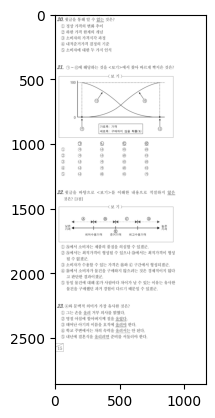

In [35]:
from matplotlib.pyplot import imshow
from PIL import Image

f_name = r'C:\Users\hana9\preprocessing\a_kor_test\2015_G1_11_KOR\cropped\2015_G1_11_KOR_right__page6.png'

%matplotlib inline
pil_im = Image.open(f_name, 'r')
imshow(pil_im)

import easyocr

# easy-ocr
reader = easyocr.Reader(['ko','en'])
txt = reader.readtext(f_name)
txt